# INTRO

## Notebook for applying Data Assimilation on modern data (Based on Caldarescu et al., 2021 data from Gulf of Panama)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point
### Assemble data in SST (D47), SAT (D47), SSS (d18Oc) and precipitation domain (SSS data as measurements, not modelled)

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**

*Data assimiliation*
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

*Data sources*
- Caldarescu, D. E., Sadatzki, H., Andersson, C., Schäfer, P., Fortunato, H., and Meckler, A. N.: Clumped isotope thermometry in bivalve shells: A tool for reconstructing seasonal upwelling, Geochimica et Cosmochimica Acta, 294, 174–191, https://doi.org/10.1016/j.gca.2020.11.019, 2021.
- Gutiérrez, J.M., R.G. Jones, G.T. Narisma, L.M. Alves, M. Amjad, I.V.Gorodetskaya, M. Grose, N.A.B. Klutse, S. Krakovska, J. Li, D.Martínez-Castro, L.O. Mearns, S.H. Mernild, T. Ngo-Duc, B. van den Hurk, and J.-H. Yoon, 2021: Atlas. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, et al. (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1927–2058, doi:10.1017/9781009157896.021. Interactive Atlas available from http://interactive-atlas.ipcc.ch/
- Iturbide, M., Fernández, J., Gutiérrez, J.M. et al. Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository. Sci Data 9, 629 (2022). https://doi.org/10.1038/s41597-022-01739-y
- Boutin, J.; Vergely, J.-L.; Koehler, J.; Rouffi, F.; Reul, N. (2019): ESA Sea Surface Salinity Climate Change Initiative (Sea_Surface_Salinity_cci): Weekly Sea Surface Salinity product v1.8. Centre for Environmental Data Analysis, date of citation. https://catalogue.ceda.ac.uk/uuid/e5666094722c4ca787e323a9585b0a92
- SST Monitoring - Physical Monitoring | Smithsonian Tropical Research Institute, Physical Monitoring, [URL](https://striresearch.si.edu/physical-monitoring/sst-monitoring/)


*Calibration equations*
- Graniero, L. E., Grossman, E. L., Robbins, J., Morales, J., Thompson, R., and O’Dea, A.: Conus Shell δ13C values as proxies for δ13CDIC in tropical waters, Palaeogeography, Palaeoclimatology, Palaeoecology, 472, 119–127, https://doi.org/10.1016/j.palaeo.2017.02.007, 2017.
- Daëron, M. and Vermeesch, P.: Omnivariant generalized least squares regression: Theory, geochronological applications, and making the case for reconciled Δ47 calibrations, Chemical Geology, 121881, https://doi.org/10.1016/j.chemgeo.2023.121881, 2023.
- Grossman, E. L. and Ku, T.-L.: Oxygen and carbon isotope fractionation in biogenic aragonite: temperature effects, Chemical Geology: Isotope Geoscience section, 59, 59–74, 1986.
- Gonfiantini, R., Stichler, W., and Rozanski, K.: Standards and intercomparison materials distributed by the International Atomic Energy Agency for stable isotope measurements, 1995.
- Dettman, D. L., Reische, A. K., and Lohmann, K. C.: Controls on the stable isotope composition of seasonal growth bands in aragonitic fresh-water bivalves (Unionidae), Geochimica et Cosmochimica Acta, 63, 1049–1057, 1999.

## Load packages

In [163]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [164]:
# Load model SST data as prior and show data structure
IPCC_Atlas_SST = pd.read_csv('Modern case/SSTdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_SST = IPCC_Atlas_SST.pivot(index=['lat', 'lon'], columns='month', values='tos').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_SST.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_SST.head()

month  lat   lon         ar         ag         dc         fb         ja  \
0      7.5 -81.5  27.870666  28.807864  28.234173  27.020926  27.569698   
1      7.5 -80.5  26.808416  27.472491  28.242612  26.442010  27.180057   
2      7.5 -79.5  26.814397  28.957019  28.453653  26.170235  27.295458   
3      7.5 -78.5  26.891758  29.054418  28.537700  26.116582  27.303514   
4      7.5 -77.5        NaN        NaN        NaN        NaN        NaN   

month         jl         jn         mr         my         nv         ot  \
0      28.706740  28.716516  27.074181  28.717969  28.279754  28.346880   
1      27.630609  27.446476  26.412426  27.232879  28.372525  27.958568   
2      28.806538  28.734703  26.018813  28.156229  28.510441  28.605194   
3      28.938615  28.816935  26.014780  28.164300  28.650586  28.788851   
4            NaN        NaN        NaN        NaN        NaN        NaN   

month         sp  
0      28.698233  
1      27.736655  
2      28.915533  
3      29.053953  
4            NaN

## Load monthly SAT model data

In [165]:
# Load model SAT data as prior and show data structure
IPCC_Atlas_SAT = pd.read_csv('Modern case/SATdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_SAT = IPCC_Atlas_SAT.pivot(index=['lat', 'lon'], columns='month', values='tas').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_SAT.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_SAT.head()

month  lat   lon         ar         ag         dc         fb         ja  \
0      7.5 -81.5  27.583176  26.552208  26.558420  26.835735  26.682741   
1      7.5 -80.5  27.275017  26.536266  26.511211  26.583742  26.550386   
2      7.5 -79.5  27.001470  26.600628  26.552113  26.399340  26.497887   
3      7.5 -78.5  26.625885  26.183826  26.066435  26.162770  26.128641   
4      7.5 -77.5  26.058582  25.183080  24.992147  25.759280  25.274055   

month         jl         jn         mr         my         nv         ot  \
0      26.458174  26.592540  27.186361  27.313580  26.218864  26.229807   
1      26.459099  26.570900  26.928097  27.066269  26.204203  26.266203   
2      26.529715  26.607323  26.664957  26.917267  26.256363  26.311296   
3      26.111752  26.153196  26.438007  26.403248  25.779915  25.811575   
4      25.143060  25.183006  26.192318  25.495410  24.729294  24.765930   

month         sp  
0      26.476027  
1      26.487984  
2      26.543280  
3      26.081343  
4      25.051905

## Load satellite SSS data

In [166]:
# Load ESA SSS data as prior and show data structure
ESA_SSS = pd.read_csv('Modern case/SSS_Panama_all.csv')  # Load the data into Python and in the Jupyter environment.
# Convert 'timeseries' column to datetime
ESA_SSS['date'] = pd.to_datetime(ESA_SSS['date'], format='%Y%m%d')
# Rename longitude and latitude columns to 'lon' and 'lat'
ESA_SSS = ESA_SSS.rename(columns={'longitude': 'lon', 'latitude': 'lat'})

# Extract month as two-letter code
month_abbr = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
ESA_SSS['month'] = ESA_SSS['date'].dt.month.apply(lambda x: month_abbr[x-1])

# Group by lat, lon, and month, then calculate the mean salinity for each group
ESA_SSS = ESA_SSS.groupby(['lat', 'lon', 'month'], as_index=False)['salinity'].mean()

# Pivot to make one column per month, keeping all data
ESA_SSS = ESA_SSS.pivot(index=['lat', 'lon'], columns='month', values='salinity').reset_index()

ESA_SSS.head()

month  lat   lon         ag         ar         dc         fb         ja  \
0      7.0 -81.5  31.136181  33.602102  29.170102  32.022884  30.418702   
1      7.0 -80.0  30.547831  33.757785  29.370818  33.184081  31.357592   
2      7.0 -79.5  30.542582  33.867599  29.344715  33.139511  31.427747   
3      7.0 -79.0  30.390912  33.637158  29.144642  32.730496  31.008538   
4      7.0 -78.5  30.493174  33.578397  29.022538  32.151029  30.534165   

month         jl         jn         mr         my         nv         ot  \
0      31.581640  32.324151  33.077173  33.040741  29.530418  30.622286   
1      30.910315  31.892236  33.637193  33.068963  29.336099  29.891578   
2      31.004266  31.869194  33.656158  33.013782  29.361235  29.827726   
3      31.002376  31.710107  33.398851  32.775925  29.262633  29.721688   
4      31.075004  31.585485  33.202158  32.854144  29.120639  29.612904   

month         sp  
0      30.665430  
1      29.889138  
2      30.019896  
3      29.765914  
4      29.680376

## Load monthly precipitation data

In [167]:
# Load model precip data as prior and show data structure
IPCC_Atlas_precip = pd.read_csv('Modern case/precipdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_precip = IPCC_Atlas_precip.pivot(index=['lat', 'lon'], columns='month', values='pr').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_precip.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_precip.head()

month  lat   lon        ar         ag        dc        fb        ja  \
0      7.5 -81.5  1.689385  12.423080  2.590541  0.387124  0.582265   
1      7.5 -80.5  1.779216  12.493553  2.881293  0.449284  0.714600   
2      7.5 -79.5  2.001780  12.659093  3.562033  0.458198  0.814399   
3      7.5 -78.5  2.500152  13.219075  4.115735  0.685854  1.062848   
4      7.5 -77.5  3.386591  13.334969  4.033405  0.920459  1.207844   

month         jl         jn        mr        my        nv         ot  \
0      12.162777  11.670250  0.545877  6.474045  7.746123  11.768444   
1      12.262433  11.679930  0.586808  6.634595  7.909942  11.458197   
2      12.203677  11.351872  0.630577  7.039908  9.019142  12.075278   
3      12.568253  11.503000  0.875989  7.622621  9.605698  12.277294   
4      12.501793  11.494451  1.238471  8.514819  9.458278  12.520760   

month         sp  
0      12.815062  
1      12.675345  
2      12.758909  
3      13.266212  
4      13.403852

## Combine SST, SAT, SSS and precipitation data by lat and lon

In [168]:
# Merge the datasets of SST, SAT, SSS, and precipitation, force suffixes to be added to the column names
IPCC_Atlas = pd.merge(
    IPCC_Atlas_SST.rename(columns={c: c + '_SST' for c in IPCC_Atlas_SST.columns if c not in ['lat', 'lon']}),
    IPCC_Atlas_SAT.rename(columns={c: c + '_SAT' for c in IPCC_Atlas_SAT.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

IPCC_Atlas = pd.merge(
    IPCC_Atlas,
    ESA_SSS.rename(columns={c: c + '_SSS' for c in ESA_SSS.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

IPCC_Atlas = pd.merge(
    IPCC_Atlas,
    IPCC_Atlas_precip.rename(columns={c: c + '_precip' for c in IPCC_Atlas_precip.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

# Display the combined dataset
IPCC_Atlas.head()

month  lat   lon  ar_SST  ag_SST  dc_SST  fb_SST  ja_SST  jl_SST  jn_SST  \
0      7.0 -81.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      7.0 -80.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      7.0 -79.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      7.0 -79.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      7.0 -78.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

month  mr_SST  ...  dc_precip  fb_precip  ja_precip  jl_precip  jn_precip  \
0         NaN  ...        NaN        NaN        NaN        NaN        NaN   
1         NaN  ...        NaN        NaN        NaN        NaN        NaN   
2         NaN  ...        NaN        NaN        NaN        NaN        NaN   
3         NaN  ...        NaN        NaN        NaN        NaN        NaN   
4         NaN  ...        NaN        NaN        NaN        NaN        NaN   

month  mr_precip  my_precip  nv_precip  ot_precip  sp_precip  
0            NaN        NaN        NaN        NaN        NaN  
1            NaN        NaN        NaN        NaN        NaN  
2            NaN        NaN        NaN        NaN        NaN  
3            NaN        NaN        NaN        NaN        NaN  
4            NaN        NaN        NaN        NaN        NaN  

[5 rows x 50 columns]

## Calculate the monthly prior for model SST, SAT, SSS and precipitation values

In [169]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Prior SST, SAT, SSS & precipitation estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(IPCC_Atlas[[f"{month}_SAT" for month in months]].mean(axis=0, skipna=True))
mu_prior_SST_monthly = np.array(IPCC_Atlas[[f"{month}_SST" for month in months]].mean(axis=0, skipna=True))
mu_prior_SSS_monthly = np.array(IPCC_Atlas[[f"{month}_SSS" for month in months]].mean(axis=0, skipna=True))
mu_prior_precip_monthly = np.array(IPCC_Atlas[[f"{month}_precip" for month in months]].mean(axis=0, skipna=True))

# Covariance between months in prior SST, SAT, SSS, and precip estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(IPCC_Atlas[[f"{month}_SAT" for month in months]].dropna(), rowvar=False)
cov_prior_SST_monthly = np.cov(IPCC_Atlas[[f"{month}_SST" for month in months]].dropna(), rowvar=False)
cov_prior_SSS_monthly = np.cov(IPCC_Atlas[[f"{month}_SSS" for month in months]].dropna(), rowvar=False)
cov_prior_precip_monthly = np.cov(IPCC_Atlas[[f"{month}_precip" for month in months]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_precip_monthly_original, cov_prior_precip_monthly_original = mu_prior_precip_monthly.copy(), cov_prior_precip_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_precip_monthly = np.sqrt(np.diag(cov_prior_precip_monthly))

print("SAT Monthly Means:", mu_prior_SAT_monthly)
print("SAT Monthly Std Devs:", std_prior_SAT_monthly)
print("SST Monthly Means:", mu_prior_SST_monthly)
print("SST Monthly Std Devs:", std_prior_SST_monthly)
print("SSS Monthly Means:", mu_prior_SSS_monthly)
print("SSS Monthly Std Devs:", std_prior_SSS_monthly)
print("Precip Monthly Means:", mu_prior_precip_monthly)
print("Precip Monthly Std Devs:", std_prior_precip_monthly)

SAT Monthly Means: [26.19674833 26.2856926  26.61780667 26.9355932  26.83360707 26.53449047
 26.469068   26.5685366  26.55148913 26.3253362  26.23056327 26.30819593]
SAT Monthly Std Devs: [0.47312434 0.41409864 0.41961986 0.45581423 0.52380544 0.58817398
 0.60908107 0.63073153 0.65805864 0.67241717 0.66092167 0.57625065]
SST Monthly Means: [27.44732929 26.77931444 26.66707259 27.07042812 27.81826605 28.38219858
 28.62096962 28.7972226  29.09194208 29.15567638 28.99711452 28.42136266]
SST Monthly Std Devs: [0.38677244 0.81134486 1.05313182 1.09679318 1.00268654 0.70288835
 0.47347404 0.48010207 0.46942236 0.53116255 0.47287623 0.36093464]
SSS Monthly Means: [33.86770403 34.75316948 35.11282266 35.19246591 34.78473881 34.14922047
 33.78734812 33.57020955 33.2435436  33.29892228 32.98168314 32.88601062]
SSS Monthly Std Devs: [2.13464657 1.41668546 1.12193259 1.02012038 1.31459478 1.82557186
 2.08893127 2.28223783 2.53931182 2.71141655 2.92807009 2.78038782]
Precip Monthly Means: [ 0.95326

## Plot the monthly priors for all model values

[Text(1, 0, 'January'),
 Text(2, 0, 'February'),
 Text(3, 0, 'March'),
 Text(4, 0, 'April'),
 Text(5, 0, 'May'),
 Text(6, 0, 'June'),
 Text(7, 0, 'July'),
 Text(8, 0, 'August'),
 Text(9, 0, 'September'),
 Text(10, 0, 'October'),
 Text(11, 0, 'November'),
 Text(12, 0, 'December')]

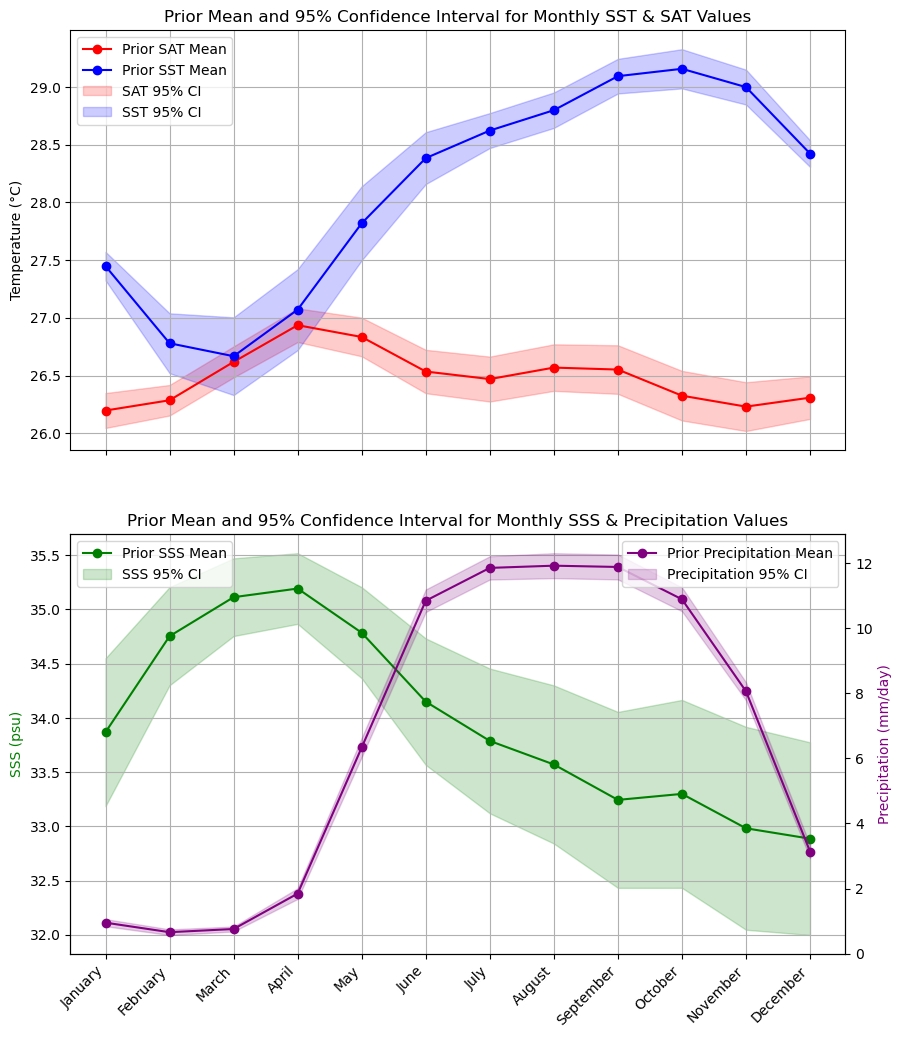

In [170]:
# Set dimensions of data
n_gridcells_monthly = len(IPCC_Atlas["lat"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Update the x-axis with month names
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation=45, ha="right")

### Convert SST and SAT model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [171]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST and SAT columns separately
SST_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SST')]
SAT_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SAT')]

# Apply the conversion function to the SST and SAT columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SST_D47'], IPCC_Atlas[f'{base_col_name}_SST_D47_SE'] = zip(*IPCC_Atlas[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SST' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SAT_D47'], IPCC_Atlas[f'{base_col_name}_SAT_D47_SE'] = zip(*IPCC_Atlas[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in IPCC_Atlas.columns if col.endswith('_D47')]
D47_se_columns = [col for col in IPCC_Atlas.columns if '_D47_SE' in col]
print("D47 values for all grid cells:\n", IPCC_Atlas[D47_columns].head())
print("Calibration standard errors for all grid cells:\n", IPCC_Atlas[D47_se_columns].head())

D47 values for all grid cells:
 month  ar_SST_D47  ag_SST_D47  dc_SST_D47  fb_SST_D47  ja_SST_D47  jl_SST_D47  \
0             NaN         NaN         NaN         NaN         NaN         NaN   
1             NaN         NaN         NaN         NaN         NaN         NaN   
2             NaN         NaN         NaN         NaN         NaN         NaN   
3             NaN         NaN         NaN         NaN         NaN         NaN   
4             NaN         NaN         NaN         NaN         NaN         NaN   

month  jn_SST_D47  mr_SST_D47  my_SST_D47  nv_SST_D47  ...  dc_SAT_D47  \
0             NaN         NaN         NaN         NaN  ...         NaN   
1             NaN         NaN         NaN         NaN  ...         NaN   
2             NaN         NaN         NaN         NaN  ...         NaN   
3             NaN         NaN         NaN         NaN  ...         NaN   
4             NaN         NaN         NaN         NaN  ...         NaN   

month  fb_SAT_D47  ja_SAT_D47  jl_SA

### Estimate seawater oxygen isotope value from salinity based on modern Gulf of Panama d18Ow-salinity relationship by Graniero et al. (2017; rainy season)

In [172]:
# Apply the d18Ow-SSS function from Graniero et al. (2017) to all SSS columns
# Identify the SSS columns
SSS_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SSS')]

# Apply the conversion function to the SSS columns and add new columns for d18Ow and d18Ow_SE
for col in SSS_columns:
    base_col_name = col.replace('_SSS', '')  # Remove the '_SSS' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SSS_d18Ow'] = IPCC_Atlas[col].apply(
        lambda x: -7.89 + 0.23 * x if not pd.isna(x) else np.nan  # Calculate d18Ow
    )

# Display the combined data with d18Ow and d18Ow_SE columns
d18Ow_columns = [col for col in IPCC_Atlas.columns if col.endswith('_d18Ow')]
print("d18Ow values for all model outcomes:\n", IPCC_Atlas[d18Ow_columns].head())

d18Ow values for all model outcomes:
 month  ag_SSS_d18Ow  ar_SSS_d18Ow  dc_SSS_d18Ow  fb_SSS_d18Ow  ja_SSS_d18Ow  \
0         -0.728678     -0.161517     -1.180877     -0.524737     -0.893698   
1         -0.863999     -0.125709     -1.134712     -0.257661     -0.677754   
2         -0.865206     -0.100452     -1.140716     -0.267912     -0.661618   
3         -0.900090     -0.153454     -1.186732     -0.361986     -0.758036   
4         -0.876570     -0.166969     -1.214816     -0.495263     -0.867142   

month  jl_SSS_d18Ow  jn_SSS_d18Ow  mr_SSS_d18Ow  my_SSS_d18Ow  nv_SSS_d18Ow  \
0         -0.626223     -0.455445     -0.282250     -0.290629     -1.098004   
1         -0.780628     -0.554786     -0.153446     -0.284138     -1.142697   
2         -0.759019     -0.560085     -0.149084     -0.296830     -1.136916   
3         -0.759453     -0.596675     -0.208264     -0.351537     -1.159595   
4         -0.742749     -0.625339     -0.253504     -0.333547     -1.192253   

month  ot_SS

### Calculate carbonate oxygen isotope value from SST and seawater oxygen isotope data using Grossman and Ku (1986) with the VPDB-VSMOW scale correction by Gonfiantini et al. (1995) and Dettman et al. (1999)

In [173]:
# Iterate over each model and calculate d18Oc values
for index, row in IPCC_Atlas.iterrows():
    # Iterate over each month
    for month in months:
        SST = row[f"{month}_SST"]
        d18Ow = row[f"{month}_SSS_d18Ow"]
        if not pd.isna(SST) and not pd.isna(d18Ow):
            d18Oc = (20.6 - SST) / 4.34 + (d18Ow - 0.27)
        else:
            d18Oc = np.nan
        # Add the calculated d18Oc value to the DataFrame
        IPCC_Atlas.loc[index, f"{month}_d18Oc"] = d18Oc

# Display the updated DataFrame
IPCC_Atlas.head()


month  lat   lon  ar_SST  ag_SST  dc_SST  fb_SST  ja_SST  jl_SST  jn_SST  \
0      7.0 -81.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      7.0 -80.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      7.0 -79.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      7.0 -79.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      7.0 -78.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

month  mr_SST  ...  mr_d18Oc  ar_d18Oc  my_d18Oc  jn_d18Oc  jl_d18Oc  \
0         NaN  ...       NaN       NaN       NaN       NaN       NaN   
1         NaN  ...       NaN       NaN       NaN       NaN       NaN   
2         NaN  ...       NaN       NaN       NaN       NaN       NaN   
3         NaN  ...       NaN       NaN       NaN       NaN       NaN   
4         NaN  ...       NaN       NaN       NaN       NaN       NaN   

month  ag_d18Oc  sp_d18Oc  ot_d18Oc  nv_d18Oc  dc_d18Oc  
0           NaN       NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN       NaN  
3           NaN       NaN       NaN       NaN       NaN  
4           NaN       NaN       NaN       NaN       NaN  

[5 rows x 122 columns]

### Calculate the monthly prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [174]:
# Set the weights of the data based on the standard errors
weights_monthly_SST_D47 = 1 / IPCC_Atlas[[f"{month}_SST_D47_SE" for month in months]] ** 2
weights_monthly_SAT_D47 = 1 / IPCC_Atlas[[f"{month}_SAT_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly_SST_D47 to match the headers of the D47 matrix later for multiplication
weights_monthly_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_monthly_SST_D47.columns]
weights_monthly_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_monthly_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_monthly = np.array((IPCC_Atlas[[f"{month}_SST_D47" for month in months]] * weights_monthly_SST_D47).sum(axis = 0, skipna = True) / weights_monthly_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array
mu_prior_SAT_D47_monthly = np.array((IPCC_Atlas[[f"{month}_SAT_D47" for month in months]] * weights_monthly_SAT_D47).sum(axis = 0, skipna = True) / weights_monthly_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Ow values
mu_prior_SSS_d18Ow_monthly = np.array(IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].mean(axis=0, skipna=True))
mu_prior_d18Oc_monthly = np.array(IPCC_Atlas[[f"{month}_d18Oc" for month in months]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST = IPCC_Atlas[[f"{month}_SST_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT = IPCC_Atlas[[f"{month}_SAT_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Ow = IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Oc = IPCC_Atlas[[f"{month}_d18Oc" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST = (IPCC_Atlas[[f"{month}_SST_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT = (IPCC_Atlas[[f"{month}_SAT_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly_SST = np.cov(IPCC_Atlas[[f"{month}_SST_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_SAT = np.cov(IPCC_Atlas[[f"{month}_SAT_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Ow = np.cov(IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Oc = np.cov(IPCC_Atlas[[f"{month}_d18Oc" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_monthly = cov_raw_monthly_SST.copy() # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_monthly = cov_raw_monthly_SAT.copy() # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_monthly, np.diagonal(cov_raw_monthly_SST) + measurement_variances_SST)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_monthly, np.diagonal(cov_raw_monthly_SAT) + measurement_variances_SAT)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_monthly_original, cov_prior_SST_D47_monthly_original = mu_prior_SST_D47_monthly.copy(), cov_prior_SST_D47_monthly.copy()
mu_prior_SAT_D47_monthly_original, cov_prior_SAT_D47_monthly_original = mu_prior_SAT_D47_monthly.copy(), cov_prior_SAT_D47_monthly.copy()
mu_prior_SSS_d18Ow_monthly_original, cov_prior_SSS_d18Ow_monthly_original = mu_prior_SSS_d18Ow_monthly.copy(), cov_raw_monthly_d18Ow.copy()
mu_prior_d18Oc_monthly_original, cov_prior_d18Oc_monthly_original = mu_prior_d18Oc_monthly.copy(), cov_raw_monthly_d18Oc.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_monthly = np.sqrt(np.diag(cov_prior_SST_D47_monthly))
std_prior_SAT_D47_monthly = np.sqrt(np.diag(cov_prior_SAT_D47_monthly))
std_prior_SSS_d18Ow_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Ow))
std_prior_d18Oc_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Oc))

# Print the results
print("Prior D47 estimates from SST in climate models (weighted mean):")
print(mu_prior_SST_D47_monthly)
print("Prior D47 estimates from SST in climate models (weighted covariance matrix):")
print(std_prior_SST_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted mean):")
print(mu_prior_SAT_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted covariance matrix):")
print(std_prior_SAT_D47_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted mean):")
print(mu_prior_SSS_d18Ow_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted covariance matrix):")
print(std_prior_SSS_d18Ow_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted mean):")
print(mu_prior_d18Oc_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted covariance matrix):")
print(std_prior_d18Oc_monthly)

Prior D47 estimates from SST in climate models (weighted mean):
[0.58611136 0.58807854 0.58840607 0.58721478 0.58502217 0.58337762
 0.5826824  0.58217063 0.58131734 0.58113373 0.58159202 0.58326221]
Prior D47 estimates from SST in climate models (weighted covariance matrix):
[0.00154225 0.00262358 0.0033056  0.00341755 0.00312591 0.00229783
 0.00172489 0.00174205 0.00171518 0.00185845 0.00171988 0.00147969]
Prior D47 estimates from SAT in climate models (weighted mean):
[0.58980992 0.58954575 0.58855954 0.5876189  0.58791991 0.58880551
 0.58899953 0.58870432 0.58875453 0.58942555 0.5897075  0.5894774 ]
Prior D47 estimates from SAT in climate models (weighted covariance matrix):
[0.0017582  0.00161882 0.00162767 0.00170748 0.0018731  0.00203748
 0.00209141 0.00214556 0.00221785 0.00226071 0.00223188 0.00201213]
Prior d18Ow estimates from SSS in climate models (weighted mean):
[-0.10042807  0.10322898  0.18594921  0.20426716  0.11048993 -0.03567929
 -0.11890993 -0.1688518  -0.24398497 -0

### Plot the monthly prior for model SST- and SAT-derived D47 values, model SSS-derived carbonate d18O values and precipitation with propagated uncertainty

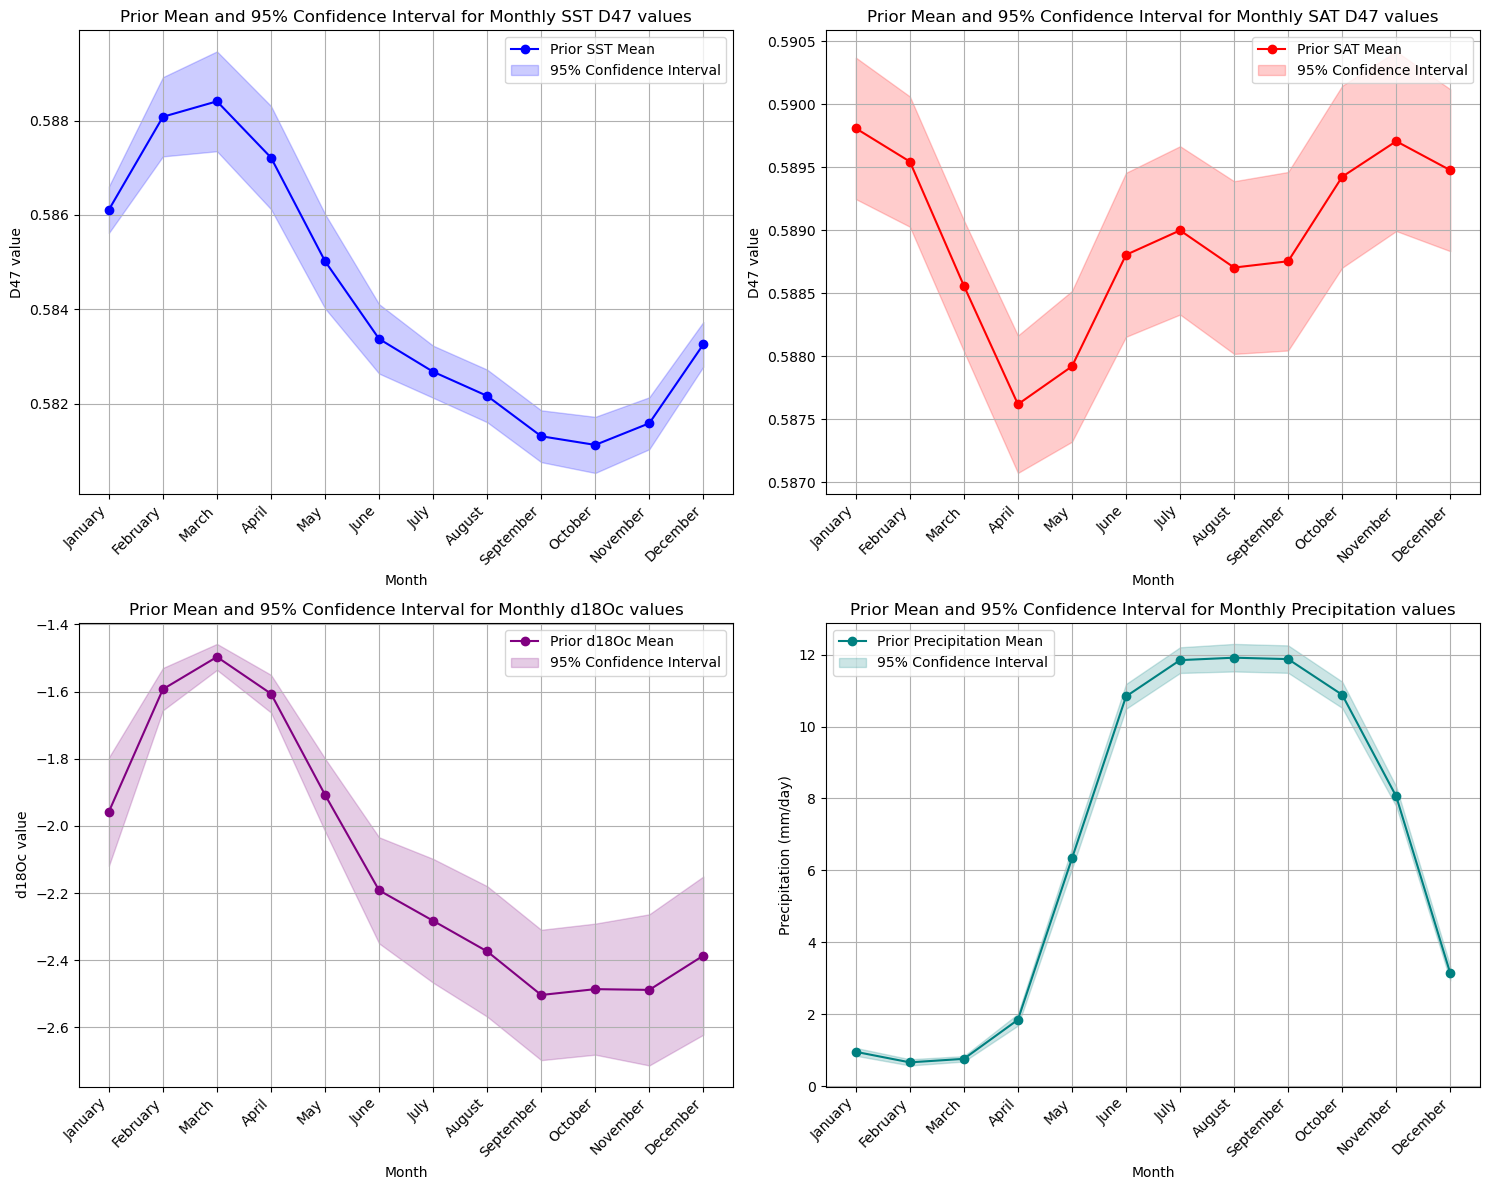

In [175]:
# Plot monthly prior distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the figure to have 2x2 grid

# Plot the prior distribution for SST
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior SST Mean', color='b', marker='o')
axes[0, 0].fill_between(months_scale,
                        mu_prior_SST_D47_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_SST_D47_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_gridcells_monthly),
                        color='b', alpha=0.2, label='95% Confidence Interval')
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST D47 values')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('D47 value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the prior distribution for SAT
axes[0, 1].plot(months_scale, mu_prior_SAT_D47_monthly, label='Prior SAT Mean', color='r', marker='o')
axes[0, 1].fill_between(months_scale,
                        mu_prior_SAT_D47_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_SAT_D47_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_gridcells_monthly),
                        color='r', alpha=0.2, label='95% Confidence Interval')
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT D47 values')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('D47 value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the prior distribution for d18Oc
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior d18Oc Mean', color='purple', marker='o')
axes[1, 0].fill_between(months_scale,
                        mu_prior_d18Oc_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_d18Oc_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_gridcells_monthly),
                        color='purple', alpha=0.2, label='95% Confidence Interval')
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly d18Oc values')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot the prior distribution for precipitation
axes[1, 1].plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', color='teal', marker='o')
axes[1, 1].fill_between(months_scale,
                        mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
                        color='teal', alpha=0.2, label='95% Confidence Interval')
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly Precipitation values')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Update the layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 values of SST and SAT, d18Oc and precipitation

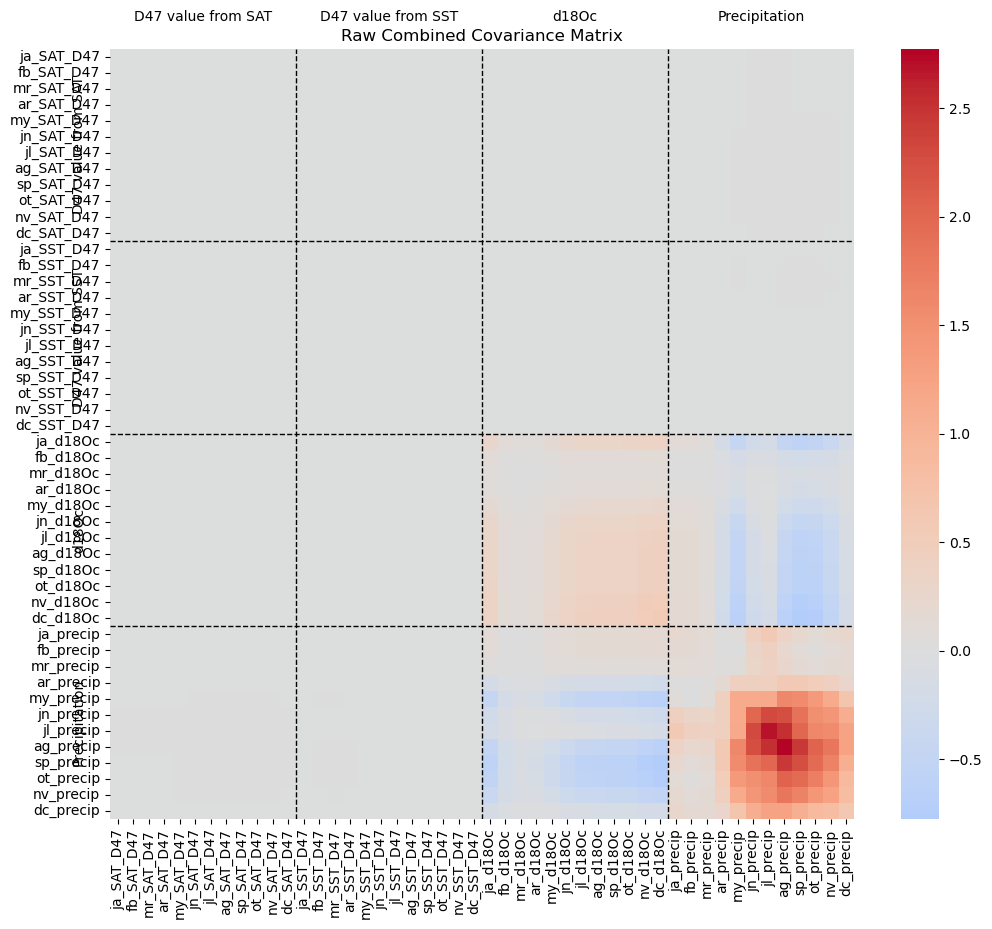

In [176]:
# Define column names for SAT, SST, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = IPCC_Atlas[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Plot the heatmap of the raw combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cov_combined_monthly,  # Use the raw covariance matrix
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-2, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Raw Combined Covariance Matrix")
plt.show()

## Plot normalized monthly covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

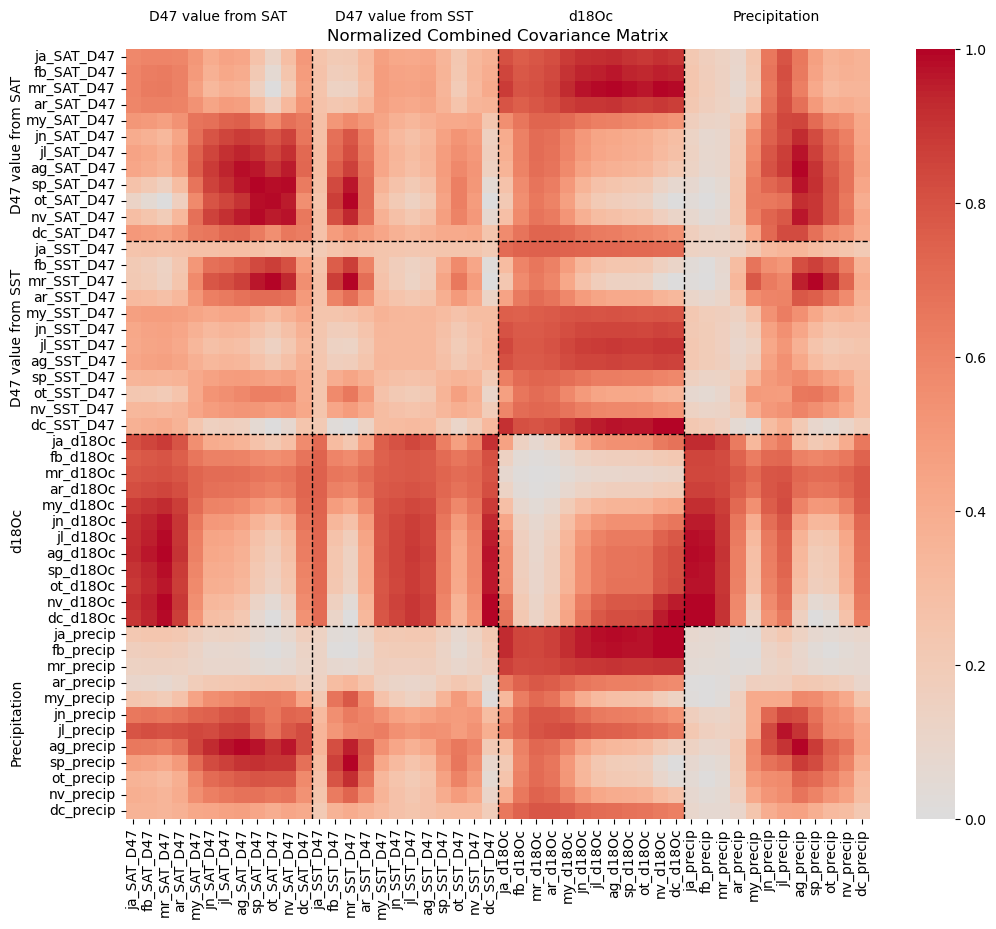

In [177]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = IPCC_Atlas[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_SST_D47_monthly = cov_combined_monthly[len(months):2*len(months), len(months):2*len(months)]
cov_d18Oc_monthly = cov_combined_monthly[2*len(months):3*len(months), 2*len(months):3*len(months)]
cov_precip_monthly = cov_combined_monthly[3*len(months):, 3*len(months):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_monthly = cov_combined_monthly[:len(months), len(months):2*len(months)]
cross_cov_SAT_d18Oc_monthly = cov_combined_monthly[:len(months), 2*len(months):3*len(months)]
cross_cov_SAT_precip_monthly = cov_combined_monthly[:len(months), 3*len(months):]
cross_cov_SST_d18Oc_monthly = cov_combined_monthly[len(months):2*len(months), 2*len(months):3*len(months)]
cross_cov_SST_precip_monthly = cov_combined_monthly[len(months):2*len(months), 3*len(months):]
cross_cov_d18Oc_precip_monthly = cov_combined_monthly[2*len(months):3*len(months), 3*len(months):]

# Normalize each submatrix
normalized_cov_SAT_D47_monthly = normalize_matrix(cov_SAT_D47_monthly)
normalized_cov_SST_D47_monthly = normalize_matrix(cov_SST_D47_monthly)
normalized_cov_d18Oc_monthly = normalize_matrix(cov_d18Oc_monthly)
normalized_cov_precip_monthly = normalize_matrix(cov_precip_monthly)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_monthly = normalize_matrix(cross_cov_SAT_SST_D47_monthly)
normalized_cross_cov_SAT_d18Oc_monthly = normalize_matrix(cross_cov_SAT_d18Oc_monthly)
normalized_cross_cov_SAT_precip_monthly = normalize_matrix(cross_cov_SAT_precip_monthly)
normalized_cross_cov_SST_d18Oc_monthly = normalize_matrix(cross_cov_SST_d18Oc_monthly)
normalized_cross_cov_SST_precip_monthly = normalize_matrix(cross_cov_SST_precip_monthly)
normalized_cross_cov_d18Oc_precip_monthly = normalize_matrix(cross_cov_d18Oc_precip_monthly)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_monthly = np.block([
    [normalized_cov_SAT_D47_monthly, normalized_cross_cov_SAT_SST_D47_monthly, normalized_cross_cov_SAT_d18Oc_monthly, normalized_cross_cov_SAT_precip_monthly],
    [normalized_cross_cov_SAT_SST_D47_monthly.T, normalized_cov_SST_D47_monthly, normalized_cross_cov_SST_d18Oc_monthly, normalized_cross_cov_SST_precip_monthly],
    [normalized_cross_cov_SAT_d18Oc_monthly.T, normalized_cross_cov_SST_d18Oc_monthly.T, normalized_cov_d18Oc_monthly, normalized_cross_cov_d18Oc_precip_monthly],
    [normalized_cross_cov_SAT_precip_monthly.T, normalized_cross_cov_SST_precip_monthly.T, normalized_cross_cov_d18Oc_precip_monthly.T, normalized_cov_precip_monthly]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_monthly,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-7, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined monthly state vector in D47 and d18Oc domain

In [178]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_SST_D47_monthly, mu_prior_SAT_D47_monthly, mu_prior_d18Oc_monthly, mu_prior_precip_monthly))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_monthly_combined = cov_combined_monthly.copy()

# PRIOR - SEASONAL

## Seasonal model data (convert the IPCC_Atlas data to seasonal means)

In [179]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create seasonal dataframes
# Initialize dictionaries to store seasonal data
IPCC_Atlas_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in IPCC_Atlas.columns if any(suffix in col for suffix in [
    '_SST', '_SAT', '_SST_D47', '_SST_D47_SE', '_SAT_D47', '_SAT_D47_SE',
    '_SSS', '_d18Oc', '_precip'
])]

# Process each season
for season, months in seasons.items():  # Iterate over the seasons and corresponding months
    for col in columns_to_process:  # Iterate over the columns to process
        base_col_name = col.split('_')[0]  # Extract the base column name
        suffix = '_'.join(col.split('_')[1:])  # Extract the suffix
        if base_col_name in months:  # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}"  # Create the new column name
            if season_col_name not in IPCC_Atlas_seasonal_dict:  # Check if the new column name already exists in the seasonal data
                IPCC_Atlas_seasonal_dict[season_col_name] = []  # If not, initialize a new column in the seasonal data means
            IPCC_Atlas_seasonal_dict[season_col_name].append(IPCC_Atlas[col])

# Combine the seasonal data into a single dataframe
IPCC_Atlas_seasonal = pd.DataFrame()
for season_col_name, data in IPCC_Atlas_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis=0).reset_index(drop=True)
    IPCC_Atlas_seasonal[season_col_name] = concatenated_data

# Add model names
IPCC_Atlas_seasonal["lat"] = np.tile(IPCC_Atlas["lat"].values, 3)  # Repeat the model names for each season
IPCC_Atlas_seasonal["lon"] = np.tile(IPCC_Atlas["lon"].values, 3)  # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if '_D47_SE' in col]
SSS_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_SSS')]
d18Oc_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_d18Oc')]
precip_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_precip')]

print("Seasonal D47 values for all SST model outcomes:\n", IPCC_Atlas_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", IPCC_Atlas_seasonal[D47_se_columns_seasonal].head())
print("Seasonal SSS values for all model outcomes:\n", IPCC_Atlas_seasonal[SSS_columns_seasonal].head())
print("Seasonal d18Oc values for all model outcomes:\n", IPCC_Atlas_seasonal[d18Oc_columns_seasonal].head())
print("Seasonal precipitation values for all model outcomes:\n", IPCC_Atlas_seasonal[precip_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_SST_D47  winter_SAT_D47  spring_SST_D47  spring_SAT_D47  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   summer_SST_D47  summer_SAT_D47  autumn_SST_D47  autumn_SAT_D47  
0             NaN             NaN             NaN             NaN  
1             NaN             NaN             NaN             NaN  
2             NaN             NaN             NaN             NaN  
3             NaN             NaN             NaN             NaN  
4             NaN             NaN             NaN             NaN  
Calibration standard errors for all SST model outcomes:
    winter_SST_D47_SE  winter_SAT_D47_SE  spring_SST_D47_SE  spring_SAT_

## Calculate the seasonal prior for model SST, SAT, SSS and precipitation with propagated uncertainty

In [180]:
# Prior estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SST_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SST" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SSS_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SSS" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Covariance between seasons in prior estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)
cov_prior_SST_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)
cov_prior_SSS_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SSS" for season in seasons]].dropna(), rowvar=False)
cov_prior_precip_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()
mu_prior_SSS_seasonal_original, cov_prior_SSS_seasonal_original = mu_prior_SSS_seasonal.copy(), cov_prior_SSS_seasonal.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_prior_precip_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))
std_prior_SSS_seasonal = np.sqrt(np.diag(cov_prior_SSS_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

# Print the results
print("SAT Seasonal Means:", mu_prior_SAT_seasonal)
print("SAT Seasonal Std Devs:", std_prior_SAT_seasonal)
print("SST Seasonal Means:", mu_prior_SST_seasonal)
print("SST Seasonal Std Devs:", std_prior_SST_seasonal)
print("SSS Seasonal Means:", mu_prior_SSS_seasonal)
print("SSS Seasonal Std Devs:", std_prior_SSS_seasonal)
print("Precipitation Seasonal Means:", mu_prior_precip_seasonal)
print("Precipitation Seasonal Std Devs:", std_prior_precip_seasonal)

SAT Seasonal Means: [26.26354562 26.79566898 26.52403169 26.36912953]
SAT Seasonal Std Devs: [0.48353899 0.47684737 0.59702245 0.66270196]
SST Seasonal Means: [27.54933547 27.18525559 28.60013027 29.08157766]
SST Seasonal Std Devs: [0.87357802 1.13352575 0.5748445  0.48432974]
SSS Seasonal Means: [33.83562805 35.03000912 33.83559272 33.17471634]
SSS Seasonal Std Devs: [2.29036665 1.15923662 2.06462247 2.70362567]
Precipitation Seasonal Means: [ 1.5836546   2.97928946 11.53320424 10.27162417]
Precipitation Seasonal Std Devs: [1.19706106 2.51465787 1.21440914 1.94491224]


## Plot the seasonal prior for model SST, SAT, SSS and measured precipitation

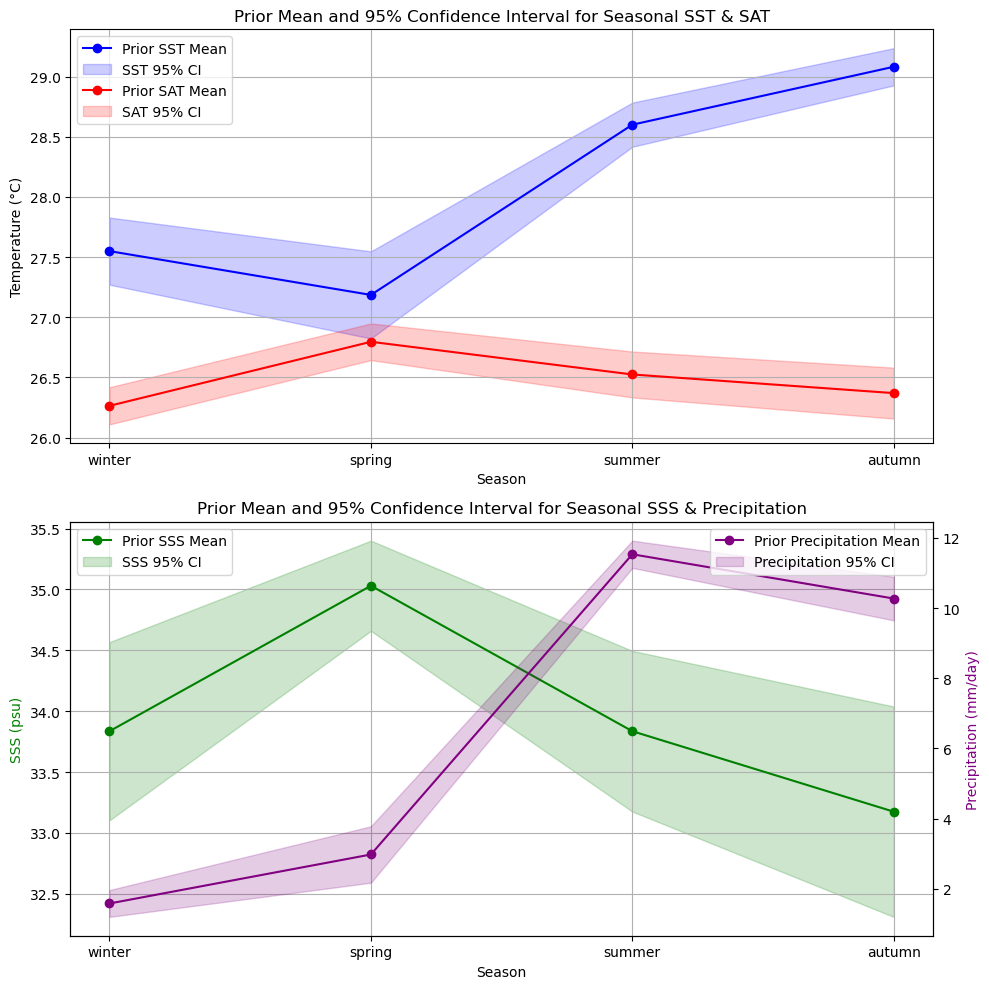

In [181]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_gridcells_seasonal = len(IPCC_Atlas["lat"])  # Find the total number of models
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 1x2 plotting grid
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o', color='b')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='b', label='SST 95% CI'
)
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='r', label='SAT 95% CI'
)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    seasons_scale,
    mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SSS & Precipitation')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal prior for model SST and SAT-derived D47 values with propagated uncertainty

In [182]:
# Set the weights of the data based on the standard errors
weights_seasonal_SST_D47 = 1 / IPCC_Atlas_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2
weights_seasonal_SAT_D47 = 1 / IPCC_Atlas_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_seasonal_SST_D47.columns]
weights_seasonal_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_seasonal_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_seasonal = np.array((IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]] * weights_seasonal_SST_D47).sum(axis = 0, skipna = True) / weights_seasonal_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array
mu_prior_SAT_D47_seasonal = np.array((IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]] * weights_seasonal_SAT_D47).sum(axis = 0, skipna = True) / weights_seasonal_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Oc values
mu_prior_d18Oc_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_d18Oc" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST_D47 = IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT_D47 = IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST_D47 = (IPCC_Atlas_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT_D47 = (IPCC_Atlas_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal_SST_D47 = np.cov(IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_SAT_D47 = np.cov(IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_d18Oc = np.cov(IPCC_Atlas_seasonal[[f"{season}_d18Oc" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_precip = np.cov(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_seasonal = cov_raw_seasonal_SST_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_seasonal = cov_raw_seasonal_SAT_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_d18Oc_seasonal = cov_raw_seasonal_d18Oc.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_precip_seasonal = cov_raw_seasonal_precip.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_seasonal, np.diagonal(cov_raw_seasonal_SST_D47) + measurement_variances_SST_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_seasonal, np.diagonal(cov_raw_seasonal_SAT_D47) + measurement_variances_SAT_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_seasonal_original, cov_prior_SST_D47_seasonal_original = mu_prior_SST_D47_seasonal.copy(), cov_prior_SST_D47_seasonal.copy()
mu_prior_SAT_D47_seasonal_original, cov_prior_SAT_D47_seasonal_original = mu_prior_SAT_D47_seasonal.copy(), cov_prior_SAT_D47_seasonal.copy()
mu_prior_d18Oc_seasonal_original, cov_prior_d18Oc_seasonal_original = mu_prior_d18Oc_seasonal.copy(), cov_raw_seasonal_d18Oc.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_raw_seasonal_precip.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_seasonal = np.sqrt(np.diag(cov_prior_SST_D47_seasonal))
std_prior_SAT_D47_seasonal = np.sqrt(np.diag(cov_prior_SAT_D47_seasonal))
std_prior_d18Oc_seasonal = np.sqrt(np.diag(cov_prior_d18Oc_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

print("mu_prior_SST_D47_seasonal:", mu_prior_SST_D47_seasonal)
print("std_prior_SST_D47_seasonal:", std_prior_SST_D47_seasonal)
print("mu_prior_SAT_D47_seasonal:", mu_prior_SAT_D47_seasonal)
print("std_prior_SAT_D47_seasonal:", std_prior_SAT_D47_seasonal)
print("mu_prior_d18Oc_seasonal:", mu_prior_d18Oc_seasonal)
print("std_prior_d18Oc_seasonal:", std_prior_d18Oc_seasonal)
print("mu_prior_precip_seasonal:", mu_prior_precip_seasonal)
print("std_prior_precip_seasonal:", std_prior_precip_seasonal)

mu_prior_SST_D47_seasonal: [0.58581025 0.58687706 0.58274323 0.58134767]
std_prior_SST_D47_seasonal: [0.00277616 0.00351338 0.00197095 0.00174785]
mu_prior_SAT_D47_seasonal: [0.58961097 0.58803244 0.58883642 0.58929545]
std_prior_SAT_D47_seasonal: [0.00178228 0.00175895 0.00205975 0.00223382]
mu_prior_d18Oc_seasonal: [-1.97907512 -1.67030341 -2.28282881 -2.49276229]
std_prior_d18Oc_seasonal: [0.59340438 0.27951935 0.52582843 0.59480091]
mu_prior_precip_seasonal: [ 1.5836546   2.97928946 11.53320424 10.27162417]
std_prior_precip_seasonal: [1.19706106 2.51465787 1.21440914 1.94491224]


## Plot the seasonal prior for model SST- and SAT-derived D47 values, d18Oc values and precipitation with propagated uncertainty

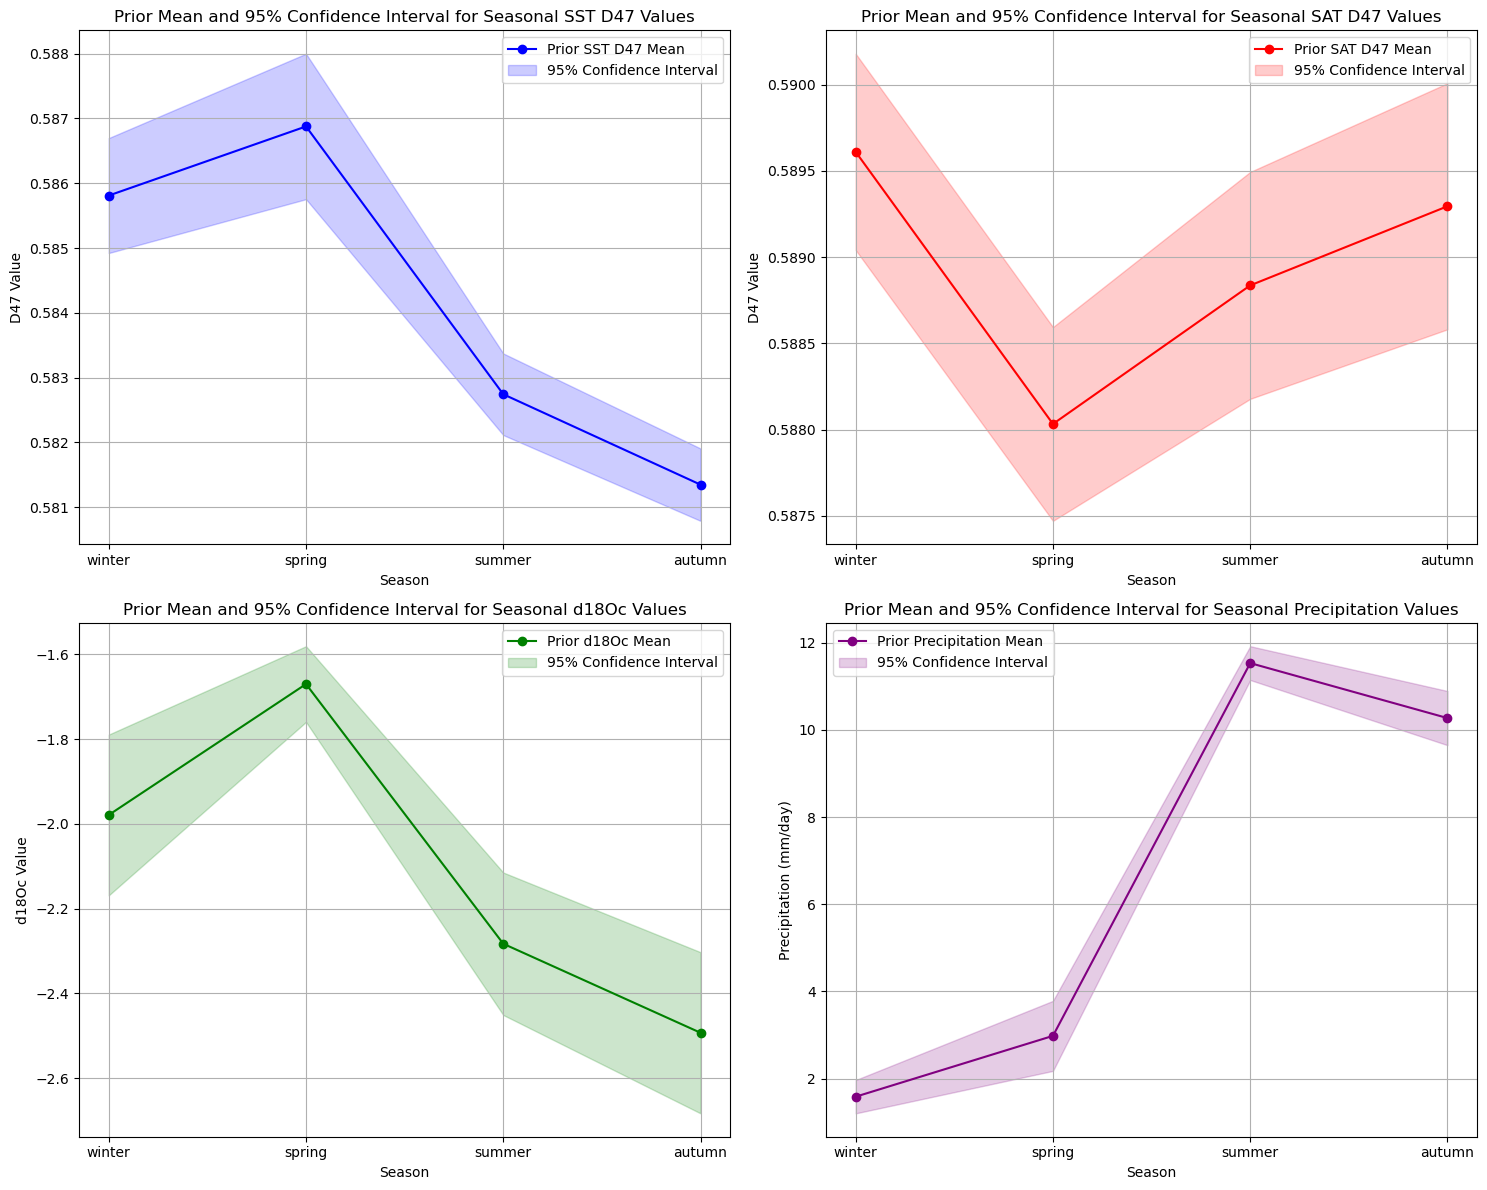

In [183]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_gridcells_seasonal = len(IPCC_Atlas["lat"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 2x2 plotting grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Plot the prior distribution for SST D47 values
axes[0, 0].plot(seasons_scale, mu_prior_SST_D47_seasonal[:len(seasons)], label='Prior SST D47 Mean', marker='o', color='b')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='b', label='95% Confidence Interval'
)
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST D47 Values')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('D47 Value')
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Panel 2: Plot the prior distribution for SAT D47 values
axes[0, 1].plot(seasons_scale, mu_prior_SAT_D47_seasonal[:len(seasons)], label='Prior SAT D47 Mean', marker='o', color='r')
axes[0, 1].fill_between(
    seasons_scale,
    mu_prior_SAT_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='r', label='95% Confidence Interval'
)
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT D47 Values')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('D47 Value')
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Panel 3: Plot the prior distribution for d18Oc
axes[1, 0].plot(seasons_scale, mu_prior_d18Oc_seasonal, label='Prior d18Oc Mean', marker='o', color='g')
axes[1, 0].fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_d18Oc_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='g', label='95% Confidence Interval'
)
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal d18Oc Values')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('d18Oc Value')
axes[1, 0].set_xticks(seasons_scale)
axes[1, 0].set_xticklabels(seasons)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Panel 4: Plot the prior distribution for precipitation
axes[1, 1].plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')
axes[1, 1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='purple', label='95% Confidence Interval'
)
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal Precipitation Values')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].set_xticks(seasons_scale)
axes[1, 1].set_xticklabels(seasons)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 values derived from SST and SAT values, d18Oc and precipitation

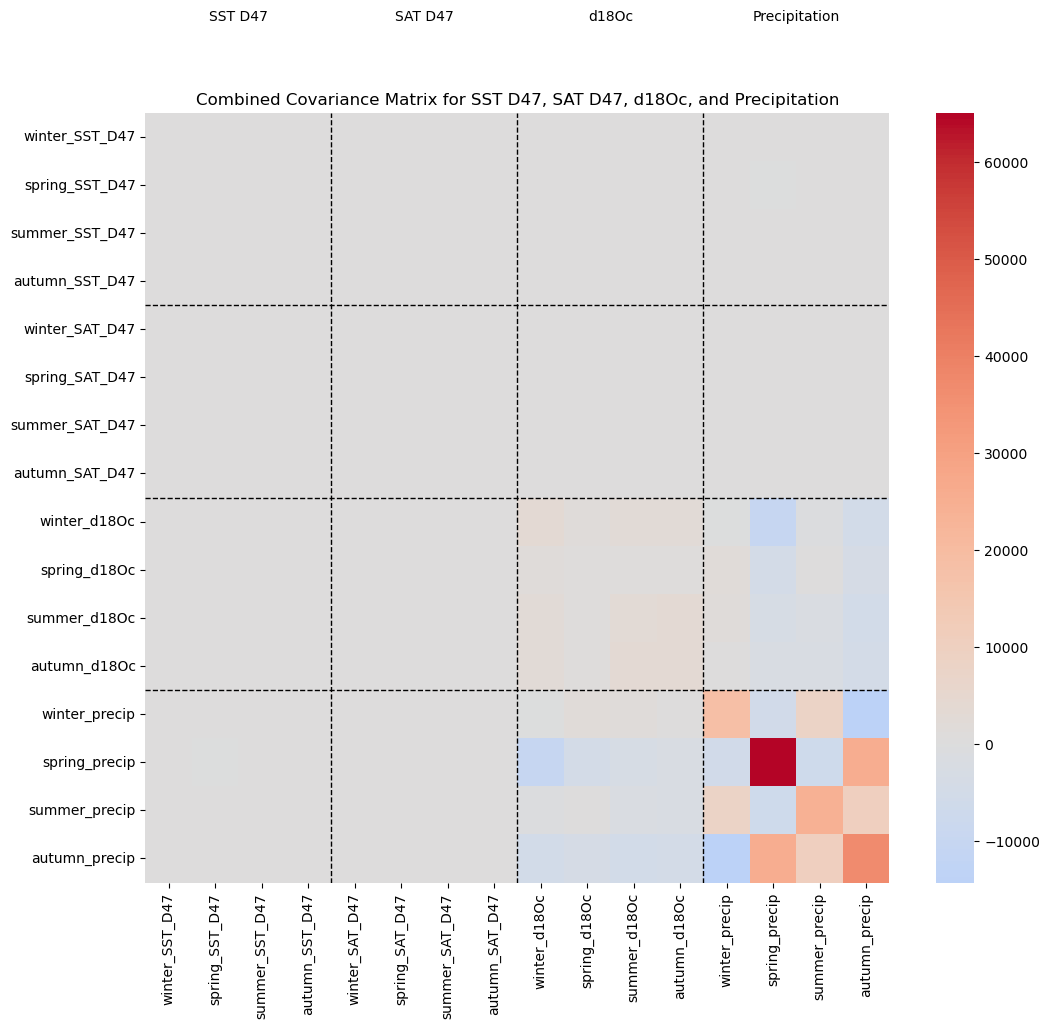

In [184]:
# Extract the relevant columns for SST, SAT D47, d18Oc, and precipitation
SST_D47_columns_seasonal = [f"{season}_SST_D47" for season in seasons]
SAT_D47_columns_seasonal = [f"{season}_SAT_D47" for season in seasons]
d18Oc_columns_seasonal = [f"{season}_d18Oc" for season in seasons]
precip_columns_seasonal = [f"{season}_precip" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = IPCC_Atlas_seasonal[
    SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar=False)

# Extract the covariance matrices for each variable
cov_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SAT_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SST_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    np.round(cov_combined_seasonal * 10**4, 1),  # Scale by 10^4 for better visualization and round values
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SST_D47_columns_seasonal) / 2, -2, 'SST D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) / 2, -2, 'SAT D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.title("Combined Covariance Matrix for SST D47, SAT D47, d18Oc, and Precipitation")
plt.show()

## Plot normalized seasonal covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

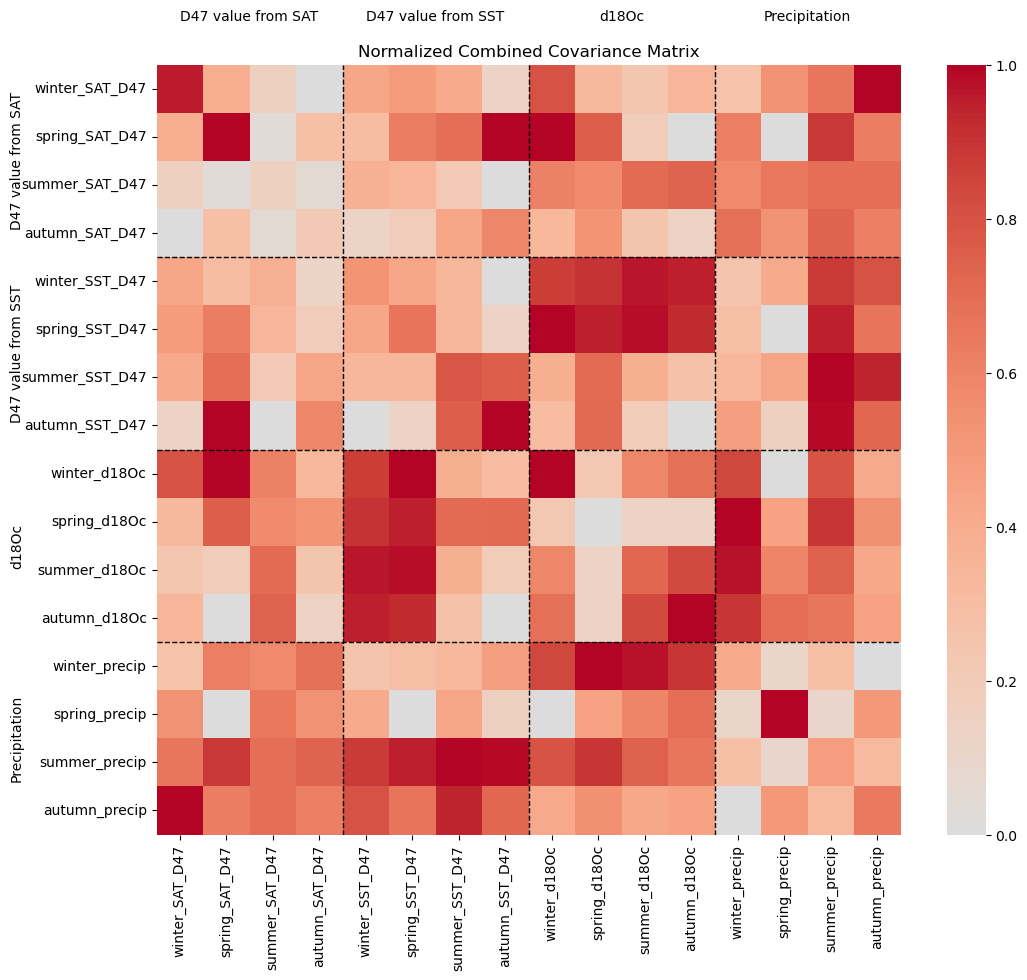

In [185]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SST_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Normalize each submatrix
normalized_cov_SAT_D47_seasonal = normalize_matrix(cov_SAT_D47_seasonal)
normalized_cov_SST_D47_seasonal = normalize_matrix(cov_SST_D47_seasonal)
normalized_cov_d18Oc_seasonal = normalize_matrix(cov_d18Oc_seasonal)
normalized_cov_precip_seasonal = normalize_matrix(cov_precip_seasonal)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_seasonal = normalize_matrix(cross_cov_SAT_SST_D47_seasonal)
normalized_cross_cov_SAT_d18Oc_seasonal = normalize_matrix(cross_cov_SAT_d18Oc_seasonal)
normalized_cross_cov_SAT_precip_seasonal = normalize_matrix(cross_cov_SAT_precip_seasonal)
normalized_cross_cov_SST_d18Oc_seasonal = normalize_matrix(cross_cov_SST_d18Oc_seasonal)
normalized_cross_cov_SST_precip_seasonal = normalize_matrix(cross_cov_SST_precip_seasonal)
normalized_cross_cov_d18Oc_precip_seasonal = normalize_matrix(cross_cov_d18Oc_precip_seasonal)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_seasonal = np.block([
    [normalized_cov_SAT_D47_seasonal, normalized_cross_cov_SAT_SST_D47_seasonal, normalized_cross_cov_SAT_d18Oc_seasonal, normalized_cross_cov_SAT_precip_seasonal],
    [normalized_cross_cov_SAT_SST_D47_seasonal.T, normalized_cov_SST_D47_seasonal, normalized_cross_cov_SST_d18Oc_seasonal, normalized_cross_cov_SST_precip_seasonal],
    [normalized_cross_cov_SAT_d18Oc_seasonal.T, normalized_cross_cov_SST_d18Oc_seasonal.T, normalized_cov_d18Oc_seasonal, normalized_cross_cov_d18Oc_precip_seasonal],
    [normalized_cross_cov_SAT_precip_seasonal.T, normalized_cross_cov_SST_precip_seasonal.T, normalized_cross_cov_d18Oc_precip_seasonal.T, normalized_cov_precip_seasonal]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_seasonal,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_seasonal) / 2, -1, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, -1, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -1, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -1, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-3, len(SAT_D47_columns_seasonal) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined seasonal state vector

In [186]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_SST_D47_seasonal, mu_prior_SAT_D47_seasonal, mu_prior_d18Oc_seasonal, mu_prior_precip_seasonal))

# Combine the covariance matrices of D47 values of SST and SAT, d18Oc and precipitation including the cross-covariance
cov_prior_seasonal_combined = cov_combined_seasonal.copy()

# OBSERVATIONS
## Load clumped data for updating

### Monthly and seasonal data based on age model

In [187]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Caldarescu_data = pd.read_csv('Modern case/Caldarescu_data.csv') # Load the data into Python and in the Jupyter environment.
Caldarescu_data_dict = Caldarescu_data.to_dict('records') # Convert to dictionary with column headers as keys

# Convert estimated day of year to month (0-11) and season (0-3), set errors to 0
for record in Caldarescu_data_dict:
    doy = record.get("Estimated day of year", np.nan)
    if not pd.isna(doy):
        record["month_score"] = int(doy / 365 * 12) % 12  # month index 0-11
        record["season_score"] = int(doy / 365 * 4) % 4    # season index 0-3
    else:
        record["month_score"] = np.nan
        record["season_score"] = np.nan
    record["Month_err"] = 0
    record["Season_err"] = 0

# Print excerpt of the dictionary to check format
print(Caldarescu_data_dict[1])

{'SampName': 'M5_115', 'Specimen': 'M5', 'SampNum': 115, 'Time of year': 'Apr/Oct', 'Increment number': 2, 'Estimated date': '01/10/2005', 'Estimated day of year': 273.0, 'Final_d13Ccarb': -0.01, 'd13C_SD': 0.030214895, 'Final_d18Ocarb_VPDB': -4.32, 'd18O_SD': 0.059240652, 'D47rfac': 0.644, 'D47': 0.582, 'D47_SD': 0.039056165, 'month_score': 8, 'season_score': 2, 'Month_err': 0, 'Season_err': 0}


## Prepare measurement and observation matrices

## Observations parsed as individual values

### Measurement matrix for individual D47 values

In [188]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
D47_measurements_individual = [measurement["D47"] for measurement in Caldarescu_data_dict if not pd.isna(measurement["D47"])] # Extract the D47 values
d18Oc_measurements_individual = [measurement["Final_d18Ocarb_VPDB"] for measurement in Caldarescu_data_dict if not pd.isna(measurement["Final_d18Ocarb_VPDB"])] # Extract the d18Oc values
D47_measurement_uncertainties_individual = [measurement["D47_SD"] ** 2 for measurement in Caldarescu_data_dict if not pd.isna(measurement["D47"])] # Square the standard deviation to get the variance
d18Oc_measurement_uncertainties_individual = [measurement["d18O_SD"] ** 2 for measurement in Caldarescu_data_dict if not pd.isna(measurement["Final_d18Ocarb_VPDB"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_individual = np.array(D47_measurements_individual + d18Oc_measurements_individual).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_individual = np.diag(D47_measurement_uncertainties_individual + d18Oc_measurement_uncertainties_individual) # Diagonal matrix of measurement uncertainties

### Monthly observation matrix for individual D47 data

In [189]:
# Create the observation matrix H for monthly data based on individual measurements
N_measurements = len(Z_individual)
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))

# Fill the first part of the observation matrix H with ones at the positions corresponding to the D47 measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["D47"])]):
    time_index = int(measurement["month_score"])
    H_monthly[i, time_index] = 1  # Indexing the first set of columns (1:12) for SST_D47

# Fill the second part of the observation matrix H with ones at the positions corresponding to the d18Oc measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["Final_d18Ocarb_VPDB"])]):
    time_index = int(measurement["month_score"])
    H_monthly[i + len(D47_measurements_individual), time_index + 24] = 1  # Indexing the third column block (25:36) for d18Oc

print(H_monthly)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Observations on seasonal scale

### Observation matrix for seasonal D47 and d18Oc data from individual D47 and d18Oc values

In [190]:
# Create the observation matrix H for seasonal data based on individual measurements

# Number of seasonally averaged measurements
H_seasonal = np.zeros((N_measurements, len(mu_prior_seasonal_combined)))

# Fill the first part of the observation matrix H with ones at the positions corresponding to the D47 measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["D47"])]):
    time_index = int(measurement["season_score"])
    H_seasonal[i, time_index] = 1  # Indexing the first set of columns (1:4) for SST_D47

# Fill the second part of the observation matrix H with ones at the positions corresponding to the d18Oc measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["Final_d18Ocarb_VPDB"])]):
    time_index = int(measurement["season_score"])
    H_seasonal[i + len(D47_measurements_individual), time_index + 8] = 1  # Indexing the third column block (8:12) for d18Oc

print(H_seasonal)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Measurement matrix for seasonally aggregated D47 values

In [191]:
# Define the list of season names for integer indexing
season_names = ["winter", "spring", "summer", "autumn"]

# Initialize dictionaries to store aggregated measurements and uncertainties per season
D47_measurements_seasonal = {season: [] for season in season_names}
d18Oc_measurements_seasonal = {season: [] for season in season_names}
D47_measurement_uncertainties_seasonal = {season: [] for season in season_names}
d18Oc_measurement_uncertainties_seasonal = {season: [] for season in season_names}
print(D47_measurements_seasonal)

for measurement in Caldarescu_data_dict:
    if not pd.isna(measurement["D47"]):
        season_index = int(measurement["season_score"])
        D47_measurements_seasonal[season_names[season_index]].append(measurement["D47"])
        D47_measurement_uncertainties_seasonal[season_names[season_index]].append(measurement["D47_SD"] ** 2)
    if not pd.isna(measurement["Final_d18Ocarb_VPDB"]):
        season_index = int(measurement["season_score"])
        d18Oc_measurements_seasonal[season_names[season_index]].append(measurement["Final_d18Ocarb_VPDB"])
        d18Oc_measurement_uncertainties_seasonal[season_names[season_index]].append(measurement["d18O_SD"] ** 2)

# Calculate weighted mean and propagated uncertainty for each season
D47_aggregated_measurements_seasonal = []
d18Oc_aggregated_measurements_seasonal = []
D47_aggregated_uncertainties_seasonal = []
d18Oc_aggregated_uncertainties_seasonal = []

for season in season_names:
    if D47_measurements_seasonal[season]:
        weights = 1 / np.array(D47_measurement_uncertainties_seasonal[season])
        weighted_mean = np.sum(np.array(D47_measurements_seasonal[season]) * weights) / np.sum(weights)
        measurement_variance = np.var(D47_measurements_seasonal[season], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        propagated_standard_error = propagated_uncertainty / np.sqrt(len(D47_measurements_seasonal[season])) # Assemble D47 data as SE (optional)
        D47_aggregated_measurements_seasonal.append(weighted_mean)
        D47_aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)
    if d18Oc_measurements_seasonal[season]:
        weights = 1 / np.array(d18Oc_measurement_uncertainties_seasonal[season])
        weighted_mean = np.sum(np.array(d18Oc_measurements_seasonal[season]) * weights) / np.sum(weights)
        measurement_variance = np.var(d18Oc_measurements_seasonal[season], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        d18Oc_aggregated_measurements_seasonal.append(weighted_mean)
        d18Oc_aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)

# OPTIONAL: Lower boundary d18Oc varaince at 0.01 (equivalent to 0.1 per mil measuremetn uncertainty)
d18Oc_aggregated_uncertainties_seasonal = [max(uncertainty, 0.01) for uncertainty in d18Oc_aggregated_uncertainties_seasonal]

# Create the measurement matrix Z
Z_seasonal_aggregated = np.array(D47_aggregated_measurements_seasonal + d18Oc_aggregated_measurements_seasonal).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_aggregated = np.diag(D47_aggregated_uncertainties_seasonal + d18Oc_aggregated_uncertainties_seasonal)  # Diagonal matrix of measurement uncertainties

print("Z_seasonal_aggregated:", Z_seasonal_aggregated)
print("R_seasonal_aggregated:", R_seasonal_aggregated)

{'winter': [], 'spring': [], 'summer': [], 'autumn': []}
Z_seasonal_aggregated: [[ 0.6203526 ]
 [ 0.60752459]
 [ 0.58873077]
 [ 0.60630233]
 [-1.66855491]
 [-2.19754098]
 [-4.05653846]
 [-2.77790698]]
R_seasonal_aggregated: [[2.25072127e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.33469318e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.07753232e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.88021380e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.22199900e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.46025638e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000000

### Observation matrix for seasonally aggregated D47 data

In [192]:
# Create the observation matrix H for seasonally aggregated data

# Define the number of seasons or months
num_seasons = 4

# Number of seasonally aggregated measurements
N_measurements_seasonal_aggregated = len(Z_seasonal_aggregated)
H_seasonal_aggregated = np.zeros((N_measurements_seasonal_aggregated, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Z_seasonal_aggregated):
    if i < N_measurements_seasonal_aggregated // 2:
        time_index = i % num_seasons  # Ensure the index is within the range of seasons
        H_seasonal_aggregated[i, time_index] = 1
    else:
        time_index = i % num_seasons
        H_seasonal_aggregated[i, time_index + 8] = 1

print(H_seasonal_aggregated)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## Observations on monthly scale

### Measurement matrix for monthly aggregated D47 values

In [193]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names

# Initialize dictionaries to store aggregated measurements and uncertainties per month
D47_measurements_monthly = {month: [] for month in month_names}
d18Oc_measurements_monthly = {month: [] for month in month_names}
D47_measurement_uncertainties_monthly = {month: [] for month in month_names}
d18Oc_measurement_uncertainties_monthly = {month: [] for month in month_names}

# Aggregate measurements and uncertainties per month
for measurement in Caldarescu_data_dict:
    if not pd.isna(measurement["D47"]):
        month_index = int(measurement["month_score"])
        D47_measurements_monthly[month_names[month_index]].append(measurement["D47"])
        D47_measurement_uncertainties_monthly[month_names[month_index]].append(measurement["D47_SD"] ** 2)
    if not pd.isna(measurement["Final_d18Ocarb_VPDB"]):
        month_index = int(measurement["month_score"])
        d18Oc_measurements_monthly[month_names[month_index]].append(measurement["Final_d18Ocarb_VPDB"])
        d18Oc_measurement_uncertainties_monthly[month_names[month_index]].append(measurement["d18O_SD"] ** 2)

# Calculate weighted mean and propagated uncertainty for each month
D47_aggregated_measurements_monthly = []
d18Oc_aggregated_measurements_monthly = []
D47_aggregated_uncertainties_monthly = []
d18Oc_aggregated_uncertainties_monthly = []

for month in month_names:
    if D47_measurements_monthly[month]:
        weights = 1 / np.array(D47_measurement_uncertainties_monthly[month])
        weighted_mean = np.sum(np.array(D47_measurements_monthly[month]) * weights) / np.sum(weights)
        measurement_variance = np.var(D47_measurements_monthly[month], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        propagated_standard_error = propagated_uncertainty / np.sqrt(len(D47_measurements_monthly[month]))  # Assemble D47 data as SE (optional)
        D47_aggregated_measurements_monthly.append(weighted_mean)
        D47_aggregated_uncertainties_monthly.append(propagated_uncertainty ** 2) # Assemble D47 data as SE
    if d18Oc_measurements_monthly[month]:
        weights = 1 / np.array(d18Oc_measurement_uncertainties_monthly[month])
        weighted_mean = np.sum(np.array(d18Oc_measurements_monthly[month]) * weights) / np.sum(weights)
        measurement_variance = np.var(d18Oc_measurements_monthly[month], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        d18Oc_aggregated_measurements_monthly.append(weighted_mean)
        d18Oc_aggregated_uncertainties_monthly.append(propagated_uncertainty ** 2)

# OPTIONAL: Lower boundary d18Oc varaince at 0.01 (equivalent to 0.1 per mil measurement uncertainty)
d18Oc_aggregated_uncertainties_monthly = [max(uncertainty, 0.01) for uncertainty in d18Oc_aggregated_uncertainties_monthly]

# Create the measurement matrix Z
Z_monthly_aggregated = np.array(D47_aggregated_measurements_monthly + d18Oc_aggregated_measurements_monthly).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly_aggregated = np.diag(D47_aggregated_uncertainties_monthly + d18Oc_aggregated_uncertainties_monthly)  # Diagonal matrix of measurement uncertainties

print("Z_monthly_aggregated:", Z_monthly_aggregated)
print("R_monthly_aggregated:", R_monthly_aggregated)

Z_monthly_aggregated: [[ 0.60602128]
 [ 0.62462903]
 [ 0.62673437]
 [ 0.60375   ]
 [ 0.61565217]
 [ 0.5994    ]
 [ 0.594375  ]
 [ 0.58444444]
 [ 0.588     ]
 [ 0.61542857]
 [ 0.616375  ]
 [ 0.60114286]
 [-2.8387234 ]
 [-1.22677419]
 [-1.2371875 ]
 [-1.7525    ]
 [-2.16      ]
 [-3.53      ]
 [-3.66625   ]
 [-4.02333333]
 [-4.43666667]
 [-1.96142857]
 [-1.995     ]
 [-3.20571429]]
R_monthly_aggregated: [[2.09378060e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.79716801e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00

### Observation matrix for monthly aggregated D47 data

In [194]:
# Create the observation matrix H for monthly aggregated data

# Define the number of seasons or months
num_months = 12

# Number of monthly aggregated measurements
N_measurements_monthly_aggregated = len(Z_monthly_aggregated)
H_monthly_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_monthly_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Z_monthly_aggregated):
    if i < N_measurements_monthly_aggregated // 2:
        time_index = i % num_months  # Ensure the index is within the range of months
        H_monthly_aggregated[i, time_index] = 1
    else:
        time_index = i % num_months
        H_monthly_aggregated[i, time_index + 24] = 1

print(H_monthly_aggregated)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# DEFINE UPDATING FUNCTIONS

## Create updating function (Kalman filter)
- Include updating of additional variables (SAT and precipitation) through cross-covariance with measured variables (D47_SST and d18Oc)
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [195]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray,
    debug_print: bool = False
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.
    debug_print (bool): If True, print debug statements.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    if debug_print:
        # Print shapes of key variables for debugging
        print("Shape of cov_prior:", cov_prior.shape)
        print("Shape of H:", H.shape)
        print("Shape of R:", R.shape)
        print("Shape of mu_prior:", mu_prior.shape)
        print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    if debug_print:
        print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior  # Compute the predicted observation
    if debug_print:
        print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1)  # Compute the innovation
    if debug_print:
        print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation  # Compute the Kalman gain
    if debug_print:
        print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior


## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [196]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
# warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics_multi(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_names = ["Variable_name1", "Variable_name2"],
    Variable_names_SDs = ["Variable_name_SD1", "Variable_name_SD2"]
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin and variable.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin and variable.
    - n_update: list
        List tracking the number of datapoints for each time bin and variable.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing data on multiple variables.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: list of str
        Key in the measurement dictionary for the variables (e.g. d18Oc, D47).
    - Variable_name_SD: list of str
        Key in the measurement dictionary for the standard deviation on the variables (e.g. d18Oc, D47).
    """
    # Check if at least one combination of variable name and its SD is present in the measurement
    found = False
    for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
        if var_name in measurement and var_sd_name in measurement:
            found = True
            break

    if timestamp in measurement and found:
        # Extract the time and data values from the measurement
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        # Loop through all variable/SD pairs
        for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
            if var_name in measurement and var_sd_name in measurement:
                data_val = measurement[var_name]
                data_sd = measurement[var_sd_name]
                
                # Check if the data is valid
                if not np.isnan(data_val) and not np.isnan(data_sd):
                    # Calculate the weight (inverse of variance)
                    weight = 1 / (data_sd ** 2)

                    # Determine the number of bins
                    num_bins_seasonal = int(len(weighted_sum) / len(Variable_names))
                    # Ensure num_bins_seasonal is an integer
                    bin_indices = np.arange(num_bins_seasonal, dtype=np.float64)

                    # Calculate the probability density for each bin
                    if time_sd == 0:  # Catch cases where the time uncertainty is zero (or unknown)
                        probabilities = np.zeros(num_bins_seasonal, dtype=np.float64)
                        bin_index = int(time) % num_bins_seasonal  # Ensure the bin index is within range
                        probabilities[bin_index] = 1  # Set the probability to 1 for the correct bin
                    else:
                        probabilities = stats.norm.pdf(bin_indices, loc=time, scale=time_sd)  # For non-zero time uncertainty, use a normal distribution
                        probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1

                    for i, prob in enumerate(probabilities):  # Loop over all possible bin numbers in the probability vector
                        bin_index = i % num_bins_seasonal  # Wrap around to the first bin if it overflows

                        # Update the weighted sums and sample count
                        effective_weight = weight * prob
                        var_idx = Variable_names.index(var_name)  # Find the index of the variable
                        idx = int(var_idx * num_bins_seasonal + bin_index)  # Unique index for (variable, bin)
                        if weighted_sum[idx] is None:
                            weighted_sum[idx] = 0
                            effective_weights_total[idx] = 0
                        weighted_sum[idx] = weighted_sum[idx] + data_val * effective_weight
                        effective_weights_total[idx] = effective_weights_total[idx] + effective_weight

                    # Update n_update for the correct variable and bin
                    var_idx = Variable_names.index(var_name) # Find the index of the variable
                    n_update[var_idx * num_bins_seasonal + (int(time) % num_bins_seasonal)] += 1  # update sample number per bin and variable

                    # Track individual data points and their uncertainties
                    key = (var_name, int(time)) # Store individual data points in a dictionary with (variable, time) as key
                    if key not in data_library:
                        data_library[key] = []  # Initialize the list for a new (time, var_name) pair
                    data_library[key].append((time_sd, data_val, data_sd))
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

# TEST UPDATING FUNCTIONS' SENSITIVITY TO INPUT UNCERTAINTY

## Load measurement data on SST, SAT, SSS and precipitation

### SST measurement data

In [197]:
sst_measurement_df = pd.read_csv("Modern case/measurement data/isla_senoritasst3_5_summary.csv")
sst_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_SST_monthly = sst_measurement_df.loc[:, sst_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_SST_monthly = sst_measurement_df.loc[:, sst_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_SST_monthly)
print(std_measurement_SST_monthly)

[26.05397715 22.93767813 22.17705242 25.16571014 27.72303465 28.34105633
 28.21574736 28.1912413  28.23161188 27.94042177 27.66587677 27.19749893]
[0.85420343 1.0662528  2.00874825 1.49485497 0.61468902 0.33940817
 0.30035706 0.29329485 0.28079002 0.33481732 0.46196816 0.73687447]


### Convert SST measurement data to D47 for comparison in D47 domain

In [198]:
# Apply T47()-function from the D47calib package to all SST data
# Define a function to convert SST to D47 and also return the standard error
def sst_to_d47(sst):
    if pd.isna(sst):
        return pd.Series({'D47': np.nan, 'D47_SE': np.nan})
    d47, d47_se = D47c.OGLS23.T47(T = sst)
    return pd.Series({'D47': d47, 'D47_SE': d47_se})

# Apply the conversion to each month
month_abbr = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Create new columns for D47 and D47_SE
sst_measurement_D47_df = pd.DataFrame()
for month in month_abbr:
    sst_measurement_D47_df[[f'{month}_D47', f'{month}_D47_SE']] = sst_measurement_df[month].apply(sst_to_d47)
# Display the updated DataFrame
sst_measurement_D47_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_SST_D47_monthly = sst_measurement_D47_df[[f'{month}_D47' for month in month_abbr]].mean(axis=0, skipna=True).values
std_measurement_SST_D47_monthly = (
    sst_measurement_D47_df[[f'{month}_D47' for month in month_abbr]].std(axis=0, skipna=True).values ** 2 + # Standard deviation of the D47 values (squared to get variance)
    sst_measurement_D47_df[[f'{month}_D47_SE' for month in month_abbr]].mean(axis=0, skipna=True).values ** 2 # Standard error as estimate for the uncertainty in the calibration (squared to get variance)
) ** 0.5  # Combine variances and take square root to get standard deviation

print(mu_measurement_SST_D47_monthly)
print(std_measurement_SST_D47_monthly)


[0.59024743 0.5996984  0.60209239 0.59292986 0.58530679 0.58349698
 0.583862   0.58393343 0.58381556 0.58466662 0.58547229 0.58685417]
[0.00276576 0.00345025 0.00632303 0.00463432 0.00207955 0.00143587
 0.0013616  0.00134927 0.00132622 0.00143199 0.00171211 0.00242267]


### SSS measurement data is equal to the prior (the measurements were used instead of model outcomes)

In [199]:
mu_measurement_SSS_monthly = mu_prior_SSS_monthly_original.copy()
std_measurement_SSS_monthly = std_prior_SSS_monthly.copy()
mu_measurement_SSS_seasonal = mu_prior_SSS_seasonal_original.copy()
std_measurement_SSS_seasonal = std_prior_SSS_seasonal.copy()

### Estimate seawater oxygen isotope value from SSS based on modern Gulf of Panama d18Ow-salinity relationship by Graniero et al. (2017; rainy season)

In [200]:
# Apply the d18Ow-SSS function from Graniero et al. (2017) to SSS data
# Identify the SSS columns
mu_measurement_d18Ow_monthly = -7.89 + 0.23 * mu_measurement_SSS_monthly.copy()
std_measurement_d18Ow_monthly = std_measurement_SSS_monthly.copy() * 0.23  # Convert SSS uncertainty to d18Ow uncertainty

print(mu_measurement_d18Ow_monthly)
print(std_measurement_d18Ow_monthly)

[-0.10042807  0.10322898  0.18594921  0.20426716  0.11048993 -0.03567929
 -0.11890993 -0.1688518  -0.24398497 -0.23124787 -0.30421288 -0.32621756]
[0.49096871 0.32583766 0.2580445  0.23462769 0.3023568  0.41988153
 0.48045419 0.5249147  0.58404172 0.62362581 0.67345612 0.6394892 ]


### Calculate d18Oc values from d18Ow and SST values using Grossman and Ku (1986) with the VPDB-VSMOW scale correction by Gonfiantini et al. (1995) and Dettman et al. (1999)

In [201]:
# Calculate d18Oc from SST and d18Ow using Grossman and Ku (1986) equation with updated d18Ow values
mu_measurement_d18Oc_monthly = (20.6 - mu_measurement_SST_monthly) / 4.34 + (mu_measurement_d18Ow_monthly - 0.27)
std_measurement_d18Oc_monthly = (
    (1 / 4.34) ** 2 * std_measurement_SST_monthly ** 2 +  # Variance from SST, corrected using the derivative of the d18Oc-temperature equation
    std_measurement_d18Ow_monthly ** 2  # Variance from d18Ow
) ** 0.5  # Combine variances and take square root to get standard deviation

print(mu_measurement_d18Oc_monthly)
print(std_measurement_d18Oc_monthly)

[-1.62710484 -0.70540653 -0.44742692 -1.11773979 -1.8007623  -2.08933282
 -2.14369043 -2.18798574 -2.27242089 -2.1925893  -2.20229508 -2.1163786 ]
[0.52895067 0.40807968 0.5299176  0.41675742 0.3338857  0.4271024
 0.48541302 0.52924704 0.58761431 0.62837949 0.68181635 0.6616449 ]


### SAT measurement data

In [202]:
sat_measurement_df = pd.read_csv("Modern case/measurement data/culebra_SAT_summary.csv")
sat_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_SAT_monthly = sat_measurement_df.loc[:, sat_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_SAT_monthly = sat_measurement_df.loc[:, sat_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_SAT_monthly)
print(std_measurement_SAT_monthly)

[27.21333333 27.09333333 27.16       27.4        27.65333333 27.44666667
 27.30666667 27.24666667 27.22666667 27.03333333 26.64666667 27.09333333]
[0.54754865 0.46053799 0.52345009 0.4840307  0.35429339 0.44859569
 0.47429145 0.34819261 0.36735865 0.41518785 0.55660536 0.81544612]


### Precipitation measurement data

In [203]:
precip_measurement_df = pd.read_csv("Modern case/measurement data/culebra_precip_summary.csv")
# Convert from mm/month to mm/day by dividing by the number of days per month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i, col in enumerate(month_abbr):
    precip_measurement_df[col] = precip_measurement_df[col] / days_per_month[i]
precip_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_precip_monthly = precip_measurement_df.loc[:, precip_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_precip_monthly = precip_measurement_df.loc[:, precip_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_precip_monthly)
print(std_measurement_precip_monthly)

[0.83193548 0.24839286 0.67225806 1.649      5.48822581 6.66116667
 5.12903226 5.50230415 6.34936508 6.50076805 7.35904762 3.10875576]
[1.10390764 0.40655457 0.63890035 1.18891228 2.18837908 2.38718687
 2.5753094  2.89484492 2.61863124 1.68515274 2.42597887 1.91788101]


## Sensitivity testing for role of uncertainty and aggregation of data

### Aggregate data while testing different combinations of enhanced uncertainty

In [204]:
# Individual datapoints
mu_post_monthlySC, cov_post_monthlySC = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC = mu_post_monthlySC[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC = cov_post_monthlySC[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC = mu_post_monthlySC[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC = cov_post_monthlySC[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data
mu_post_monthly_aggregated, cov_post_monthly_aggregated = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated = mu_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated = cov_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated = mu_post_monthly_aggregated[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated = cov_post_monthly_aggregated[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# --- HIGHER UNCERTAINTY SCENARIOS ---
# Individual data with higher uncertainty on both D47 and d18O measurements
R_individual_HU = R_individual * 10  # Increase uncertainty by a factor of 10
mu_post_monthlySC_HU, cov_post_monthlySC_HU = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_HU,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_HU = mu_post_monthlySC_HU[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_HU = cov_post_monthlySC_HU[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_HU = mu_post_monthlySC_HU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_HU = cov_post_monthlySC_HU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with higher uncertainty on both D47 and d18O measurements
R_monthly_aggregated_HU = R_monthly_aggregated * 10  # Increase uncertainty by a factor of 10
mu_post_monthly_aggregated_HU, cov_post_monthly_aggregated_HU = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_HU,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_HU = mu_post_monthly_aggregated_HU[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_HU = cov_post_monthly_aggregated_HU[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_HU = mu_post_monthly_aggregated_HU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_HU = cov_post_monthly_aggregated_HU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Individual data with higher uncertainty only on D47 measurements
R_individual_HU_D47 = R_individual.copy()
R_individual_HU_D47[:len(D47_measurement_uncertainties_individual), :len(D47_measurement_uncertainties_individual)] *= 10  # Increase uncertainty of D47 measurements by a factor of 10
mu_post_monthlySC_HU_D47, cov_post_monthlySC_HU_D47 = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_HU_D47,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_HU_D47 = mu_post_monthlySC_HU_D47[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_HU_D47 = cov_post_monthlySC_HU_D47[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_HU_D47 = mu_post_monthlySC_HU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_HU_D47 = cov_post_monthlySC_HU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with higher uncertainty only on D47 measurements
R_monthly_aggregated_HU_D47 = R_monthly_aggregated.copy()
R_monthly_aggregated_HU_D47[:len(D47_aggregated_uncertainties_monthly), :len(D47_aggregated_uncertainties_monthly)] *= 10  # Increase uncertainty of D47 measurements by a factor of 10

mu_post_monthly_aggregated_HU_D47, cov_post_monthly_aggregated_HU_D47 = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_HU_D47,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_HU_D47 = mu_post_monthly_aggregated_HU_D47[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_HU_D47 = cov_post_monthly_aggregated_HU_D47[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_HU_D47 = mu_post_monthly_aggregated_HU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_HU_D47 = cov_post_monthly_aggregated_HU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Individual data with higher uncertainty only on d18Oc measurements
R_individual_HU_d18O = R_individual.copy()
R_individual_HU_d18O[len(D47_measurements_individual):, len(D47_measurements_individual):] *= 10  # Increase uncertainty of D47 measurements by a factor of 10
mu_post_monthlySC_HU_d18O, cov_post_monthlySC_HU_d18O = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_HU_d18O,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_HU_d18O = mu_post_monthlySC_HU_d18O[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_HU_d18O = cov_post_monthlySC_HU_d18O[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_HU_d18O = mu_post_monthlySC_HU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_HU_d18O = cov_post_monthlySC_HU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with higher uncertainty only on d18Oc measurements
R_monthly_aggregated_HU_d18O = R_monthly_aggregated.copy()
R_monthly_aggregated_HU_d18O[len(D47_aggregated_uncertainties_monthly):, len(D47_aggregated_uncertainties_monthly):] *= 10  # Increase uncertainty of D47 measurements by a factor of 10

mu_post_monthly_aggregated_HU_d18O, cov_post_monthly_aggregated_HU_d18O = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_HU_d18O,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_HU_d18O = mu_post_monthly_aggregated_HU_d18O[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_HU_d18O = cov_post_monthly_aggregated_HU_d18O[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_HU_d18O = mu_post_monthly_aggregated_HU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_HU_d18O = cov_post_monthly_aggregated_HU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# --- LOWER UNCERTAINTY SCENARIOS ---
# Individual data with lower uncertainty on both D47 and d18O measurements
R_individual_LU = R_individual / 10  # Decrease uncertainty by a factor of 10
mu_post_monthlySC_LU, cov_post_monthlySC_LU = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_LU,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_LU = mu_post_monthlySC_LU[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_LU = cov_post_monthlySC_LU[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_LU = mu_post_monthlySC_LU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_LU = cov_post_monthlySC_LU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with lower uncertainty on both D47 and d18O measurements
R_monthly_aggregated_LU = R_monthly_aggregated / 10  # Decrease uncertainty by a factor of 10
mu_post_monthly_aggregated_LU, cov_post_monthly_aggregated_LU = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_LU,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_LU = mu_post_monthly_aggregated_LU[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_LU = cov_post_monthly_aggregated_LU[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_LU = mu_post_monthly_aggregated_LU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_LU = cov_post_monthly_aggregated_LU[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Individual data with lower uncertainty only on D47 measurements
R_individual_LU_D47 = R_individual.copy()
R_individual_LU_D47[:len(D47_measurement_uncertainties_individual), :len(D47_measurement_uncertainties_individual)] /= 10  # Decrease uncertainty of D47 measurements by a factor of 10
mu_post_monthlySC_LU_D47, cov_post_monthlySC_LU_D47 = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_LU_D47,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_LU_D47 = mu_post_monthlySC_LU_D47[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_LU_D47 = cov_post_monthlySC_LU_D47[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_LU_D47 = mu_post_monthlySC_LU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_LU_D47 = cov_post_monthlySC_LU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with lower uncertainty only on D47 measurements
R_monthly_aggregated_LU_D47 = R_monthly_aggregated.copy()
R_monthly_aggregated_LU_D47[:len(D47_aggregated_uncertainties_monthly), :len(D47_aggregated_uncertainties_monthly)] /= 10  # Decrease uncertainty of D47 measurements by a factor of 10
mu_post_monthly_aggregated_LU_D47, cov_post_monthly_aggregated_LU_D47 = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_LU_D47,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_LU_D47 = mu_post_monthly_aggregated_LU_D47[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_LU_D47 = cov_post_monthly_aggregated_LU_D47[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_LU_D47 = mu_post_monthly_aggregated_LU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_LU_D47 = cov_post_monthly_aggregated_LU_D47[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Individual data with lower uncertainty only on d18Oc measurements
R_individual_LU_d18O = R_individual.copy()
R_individual_LU_d18O[len(D47_measurements_individual):, len(D47_measurements_individual):] /= 10  # Decrease uncertainty of D47 measurements by a factor of 10
mu_post_monthlySC_LU_d18O, cov_post_monthlySC_LU_d18O = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_individual,
    R_individual_LU_d18O,
    H_monthly
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthlySC_LU_d18O = mu_post_monthlySC_LU_d18O[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthlySC_LU_d18O = cov_post_monthlySC_LU_d18O[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthlySC_LU_d18O = mu_post_monthlySC_LU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthlySC_LU_d18O = cov_post_monthlySC_LU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

# Aggregated data with lower uncertainty only on d18Oc measurements
R_monthly_aggregated_LU_d18O = R_monthly_aggregated.copy()
R_monthly_aggregated_LU_d18O[len(D47_aggregated_uncertainties_monthly):, len(D47_aggregated_uncertainties_monthly):] /= 10  # Decrease uncertainty of D47 measurements by a factor of 10
mu_post_monthly_aggregated_LU_d18O, cov_post_monthly_aggregated_LU_d18O = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated_LU_d18O,
    H_monthly_aggregated
)
# Extract posterior means and covariance for SST D47
mu_post_SST_D47_monthly_aggregated_LU_d18O = mu_post_monthly_aggregated_LU_d18O[:len(mu_prior_SST_D47_monthly)]
cov_post_SST_D47_monthly_aggregated_LU_d18O = cov_post_monthly_aggregated_LU_d18O[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
# Extract posterior means and covariance for d18Oc
mu_post_d18Oc_monthly_aggregated_LU_d18O = mu_post_monthly_aggregated_LU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]
cov_post_d18Oc_monthly_aggregated_LU_d18O = cov_post_monthly_aggregated_LU_d18O[2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly), 2*len(mu_prior_d18Oc_monthly):3*len(mu_prior_d18Oc_monthly)]

### Print D47 posteriors and uncertainties in a table

In [205]:
# Prepare the data for the table
data = {
    "D47 data from:": [
        "In situ measurements",
        "Individual Measurements",
        "Individual Measurements (SD D47 * 10)",
        "Individual Measurements (SD d18Oc * 10)",
        "Individual Measurements (both SDs * 10)",
        "Individual Measurements (SD D47 * 0.1)",
        "Individual Measurements (SD d18Oc * 0.1)",
        "Individual Measurements (both SDs * 0.1)",
        "Aggregated Measurements",
        "Aggregated Measurements (SD D47 * 10)",
        "Aggregated Measurements (SD d18Oc * 10)",
        "Aggregated Measurements (both SDs * 10)",
        "Aggregated Measurements (SD D47 * 0.1)",
        "Aggregated Measurements (SD d18Oc * 0.1)",
        "Aggregated Measurements (both SDs * 0.1)"
    ]
}

# Add monthly means and standard deviations to the data dictionary
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Process and rename the means and standard deviations for each data source
D47_means_individual = mu_post_SST_D47_monthlySC
D47_stds_individual = np.sqrt(np.diag(cov_post_SST_D47_monthlySC))
D47_means_individual_hu_d47 = mu_post_SST_D47_monthlySC_HU_D47
D47_stds_individual_hu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_D47))
D47_means_individual_hu_d18o = mu_post_SST_D47_monthlySC_HU_d18O
D47_stds_individual_hu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_d18O))
D47_means_individual_hu = mu_post_SST_D47_monthlySC_HU
D47_stds_individual_hu = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU))
D47_means_individual_lu_d47 = mu_post_SST_D47_monthlySC_LU_D47
D47_stds_individual_lu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_D47))
D47_means_individual_lu_d18o = mu_post_SST_D47_monthlySC_LU_d18O
D47_stds_individual_lu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_d18O))
D47_means_individual_lu = mu_post_SST_D47_monthlySC_LU
D47_stds_individual_lu = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU))

D47_means_aggregated = mu_post_SST_D47_monthly_aggregated
D47_stds_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))
D47_means_aggregated_hu_d47 = mu_post_SST_D47_monthly_aggregated_HU_D47
D47_stds_aggregated_hu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_D47))
D47_means_aggregated_hu_d18o = mu_post_SST_D47_monthly_aggregated_HU_d18O
D47_stds_aggregated_hu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_d18O))
D47_means_aggregated_hu = mu_post_SST_D47_monthly_aggregated_HU
D47_stds_aggregated_hu = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU))
D47_means_aggregated_lu_d47 = mu_post_SST_D47_monthly_aggregated_LU_D47
D47_stds_aggregated_lu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_D47))
D47_means_aggregated_lu_d18o = mu_post_SST_D47_monthly_aggregated_LU_d18O
D47_stds_aggregated_lu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_d18O))
D47_means_aggregated_lu = mu_post_SST_D47_monthly_aggregated_LU
D47_stds_aggregated_lu = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU))

# Combine all means and standard deviations into the data structure
all_D47_means = [
    mu_measurement_SST_D47_monthly,
    D47_means_individual,
    D47_means_individual_hu_d47,
    D47_means_individual_hu_d18o,
    D47_means_individual_hu,
    D47_means_individual_lu_d47,
    D47_means_individual_lu_d18o,
    D47_means_individual_lu,
    D47_means_aggregated,
    D47_means_aggregated_hu_d47,
    D47_means_aggregated_hu_d18o,
    D47_means_aggregated_hu,
    D47_means_aggregated_lu_d47,
    D47_means_aggregated_lu_d18o,
    D47_means_aggregated_lu
]
all_D47_stds = [
    std_measurement_SST_D47_monthly,
    D47_stds_individual,
    D47_stds_individual_hu_d47,
    D47_stds_individual_hu_d18o,
    D47_stds_individual_hu,
    D47_stds_individual_lu_d47,
    D47_stds_individual_lu_d18o,
    D47_stds_individual_lu,
    D47_stds_aggregated,
    D47_stds_aggregated_hu_d47,
    D47_stds_aggregated_hu_d18o,
    D47_stds_aggregated_hu,
    D47_stds_aggregated_lu_d47,
    D47_stds_aggregated_lu_d18o,
    D47_stds_aggregated_lu
]

for i, month in enumerate(months):
    data[f"{month} Mean"] = [means[i] for means in all_D47_means]
    data[f"{month} Std"] = [stds[i] for stds in all_D47_stds]

# Create the Pandas DataFrame
D47_uncertainty_test_table_df = pd.DataFrame(data)

# Set the 'Data Type' column as the index
D47_uncertainty_test_table_df = D47_uncertainty_test_table_df.set_index("D47 data from:")

# Function to format mean and std
def format_mean_std(mean, std):
    return f"{mean:.4f} ± {std:.4f}"

# Apply the formatting function to the mean and std columns
for month in months:
    D47_uncertainty_test_table_df[month] = D47_uncertainty_test_table_df.apply(lambda row: format_mean_std(row[f"{month} Mean"], row[f"{month} Std"]), axis=1)
    D47_uncertainty_test_table_df = D47_uncertainty_test_table_df.drop(columns=[f"{month} Mean", f"{month} Std"])

# Print the table
print(D47_uncertainty_test_table_df.to_string())

# Export the table to a CSV file
D47_uncertainty_test_table_df.to_csv("Sensitivity_test_D47_d18Oc_uncertainties/D47_uncertainty_test_table.csv")

# Extract monthly means of measurements
mu_likelihood_monthly_D47 = Z_monthly_aggregated[:len(mu_prior_SST_D47_monthly)].flatten()
std_likelihood_monthly_D47 = np.sqrt(np.diag(R_monthly_aggregated))[:len(mu_prior_SST_D47_monthly)].flatten()

                                                  January         February            March            April              May             June             July           August        September          October         November         December
D47 data from:                                                                                                                                                                                                                                      
In situ measurements                      0.5902 ± 0.0028  0.5997 ± 0.0035  0.6021 ± 0.0063  0.5929 ± 0.0046  0.5853 ± 0.0021  0.5835 ± 0.0014  0.5839 ± 0.0014  0.5839 ± 0.0013  0.5838 ± 0.0013  0.5847 ± 0.0014  0.5855 ± 0.0017  0.5869 ± 0.0024
Individual Measurements                   0.5891 ± 0.0004  0.5921 ± 0.0004  0.5924 ± 0.0004  0.5902 ± 0.0004  0.5877 ± 0.0003  0.5871 ± 0.0003  0.5870 ± 0.0003  0.5866 ± 0.0003  0.5851 ± 0.0003  0.5843 ± 0.0003  0.5855 ± 0.0003  0.5864 ± 0.0004
Individual Measureme

### Print d18Oc posteriors and uncertainties in a table

In [206]:
# Prepare the data for the table
data = {
    "d18Oc data from:": [
        "In situ measurements",
        "Individual Measurements",
        "Individual Measurements (SD D47 * 10)",
        "Individual Measurements (SD d18Oc * 10)",
        "Individual Measurements (both SDs * 10)",
        "Individual Measurements (SD D47 * 0.1)",
        "Individual Measurements (SD d18Oc * 0.1)",
        "Individual Measurements (both SDs * 0.1)",
        "Aggregated Measurements",
        "Aggregated Measurements (SD D47 * 10)",
        "Aggregated Measurements (SD d18Oc * 10)",
        "Aggregated Measurements (both SDs * 10)",
        "Aggregated Measurements (SD D47 * 0.1)",
        "Aggregated Measurements (SD d18Oc * 0.1)",
        "Aggregated Measurements (both SDs * 0.1)"
    ]
}

# Add monthly means and standard deviations to the data dictionary
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Process and rename the means and standard deviations for each data source
d18Oc_means_individual = mu_post_d18Oc_monthlySC
d18Oc_stds_individual = np.sqrt(np.diag(cov_post_d18Oc_monthlySC))
d18Oc_means_individual_hu_d47 = mu_post_d18Oc_monthlySC_HU_D47
d18Oc_stds_individual_hu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_D47))
d18Oc_means_individual_hu_d18o = mu_post_d18Oc_monthlySC_HU_d18O
d18Oc_stds_individual_hu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_d18O))
d18Oc_means_individual_hu = mu_post_d18Oc_monthlySC_HU
d18Oc_stds_individual_hu = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU))
d18Oc_means_individual_lu_d47 = mu_post_d18Oc_monthlySC_LU_D47
d18Oc_stds_individual_lu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_D47))
d18Oc_means_individual_lu_d18o = mu_post_d18Oc_monthlySC_LU_d18O
d18Oc_stds_individual_lu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_d18O))
d18Oc_means_individual_lu = mu_post_d18Oc_monthlySC_LU
d18Oc_stds_individual_lu = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU))

d18Oc_means_aggregated = mu_post_d18Oc_monthly_aggregated
d18Oc_stds_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))
d18Oc_means_aggregated_hu_d47 = mu_post_d18Oc_monthly_aggregated_HU_D47
d18Oc_stds_aggregated_hu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_D47))
d18Oc_means_aggregated_hu_d18o = mu_post_d18Oc_monthly_aggregated_HU_d18O
d18Oc_stds_aggregated_hu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_d18O))
d18Oc_means_aggregated_hu = mu_post_d18Oc_monthly_aggregated_HU
d18Oc_stds_aggregated_hu = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU))
d18Oc_means_aggregated_lu_d47 = mu_post_d18Oc_monthly_aggregated_LU_D47
d18Oc_stds_aggregated_lu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_D47))
d18Oc_means_aggregated_lu_d18o = mu_post_d18Oc_monthly_aggregated_LU_d18O
d18Oc_stds_aggregated_lu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_d18O))
d18Oc_means_aggregated_lu = mu_post_d18Oc_monthly_aggregated_LU
d18Oc_stds_aggregated_lu = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU))

# Combine all means and standard deviations into the data structure
all_d18Oc_means = [
    mu_measurement_d18Oc_monthly,
    d18Oc_means_individual,
    d18Oc_means_individual_hu_d47,
    d18Oc_means_individual_hu_d18o,
    d18Oc_means_individual_hu,
    d18Oc_means_individual_lu_d47,
    d18Oc_means_individual_lu_d18o,
    d18Oc_means_individual_lu,
    d18Oc_means_aggregated,
    d18Oc_means_aggregated_hu_d47,
    d18Oc_means_aggregated_hu_d18o,
    d18Oc_means_aggregated_hu,
    d18Oc_means_aggregated_lu_d47,
    d18Oc_means_aggregated_lu_d18o,
    d18Oc_means_aggregated_lu
]
all_d18Oc_stds = [
    std_measurement_d18Oc_monthly,
    d18Oc_stds_individual,
    d18Oc_stds_individual_hu_d47,
    d18Oc_stds_individual_hu_d18o,
    d18Oc_stds_individual_hu,
    d18Oc_stds_individual_lu_d47,
    d18Oc_stds_individual_lu_d18o,
    d18Oc_stds_individual_lu,
    d18Oc_stds_aggregated,
    d18Oc_stds_aggregated_hu_d47,
    d18Oc_stds_aggregated_hu_d18o,
    d18Oc_stds_aggregated_hu,
    d18Oc_stds_aggregated_lu_d47,
    d18Oc_stds_aggregated_lu_d18o,
    d18Oc_stds_aggregated_lu
]

for i, month in enumerate(months):
    data[f"{month} Mean"] = [means[i] for means in all_d18Oc_means]
    data[f"{month} Std"] = [stds[i] for stds in all_d18Oc_stds]

# Create the Pandas DataFrame
d18Oc_uncertainty_test_table_df = pd.DataFrame(data)

# Set the 'Data Type' column as the index
d18Oc_uncertainty_test_table_df = d18Oc_uncertainty_test_table_df.set_index("d18Oc data from:")

# Function to format mean and std
def format_mean_std(mean, std):
    return f"{mean:.3f} ± {std:.3f}"

# Apply the formatting function to the mean and std columns
for month in months:
    d18Oc_uncertainty_test_table_df[month] = d18Oc_uncertainty_test_table_df.apply(lambda row: format_mean_std(row[f"{month} Mean"], row[f"{month} Std"]), axis=1)
    d18Oc_uncertainty_test_table_df = d18Oc_uncertainty_test_table_df.drop(columns=[f"{month} Mean", f"{month} Std"])

# Print the table
print(d18Oc_uncertainty_test_table_df.to_string())

# Export the table to a CSV file
d18Oc_uncertainty_test_table_df.to_csv("Sensitivity_test_D47_d18Oc_uncertainties/d18Oc_uncertainty_test_table.csv")

# Extract monthly means of measurements
mu_likelihood_monthly_d18Oc = Z_monthly_aggregated[len(mu_prior_d18Oc_monthly):2*len(mu_prior_d18Oc_monthly)].flatten()
std_likelihood_monthly_d18Oc = np.sqrt(np.diag(R_monthly_aggregated))[len(mu_prior_d18Oc_monthly):2*len(mu_prior_d18Oc_monthly)].flatten()

                                                 January        February           March           April             May            June            July          August       September         October        November        December
d18Oc data from:                                                                                                                                                                                                                        
In situ measurements                      -1.627 ± 0.529  -0.705 ± 0.408  -0.447 ± 0.530  -1.118 ± 0.417  -1.801 ± 0.334  -2.089 ± 0.427  -2.144 ± 0.485  -2.188 ± 0.529  -2.272 ± 0.588  -2.193 ± 0.628  -2.202 ± 0.682  -2.116 ± 0.662
Individual Measurements                   -2.583 ± 0.007  -1.256 ± 0.006  -1.277 ± 0.004  -1.570 ± 0.006  -2.395 ± 0.008  -2.836 ± 0.008  -3.226 ± 0.007  -3.251 ± 0.010  -3.535 ± 0.009  -3.369 ± 0.006  -3.540 ± 0.006  -3.417 ± 0.007
Individual Measurements (SD D47 * 10)     -2.574 ± 0.007  -1.258 ± 0

### Plot results of uncertainty test with increased uncertainty on D47 (SST) assimilation

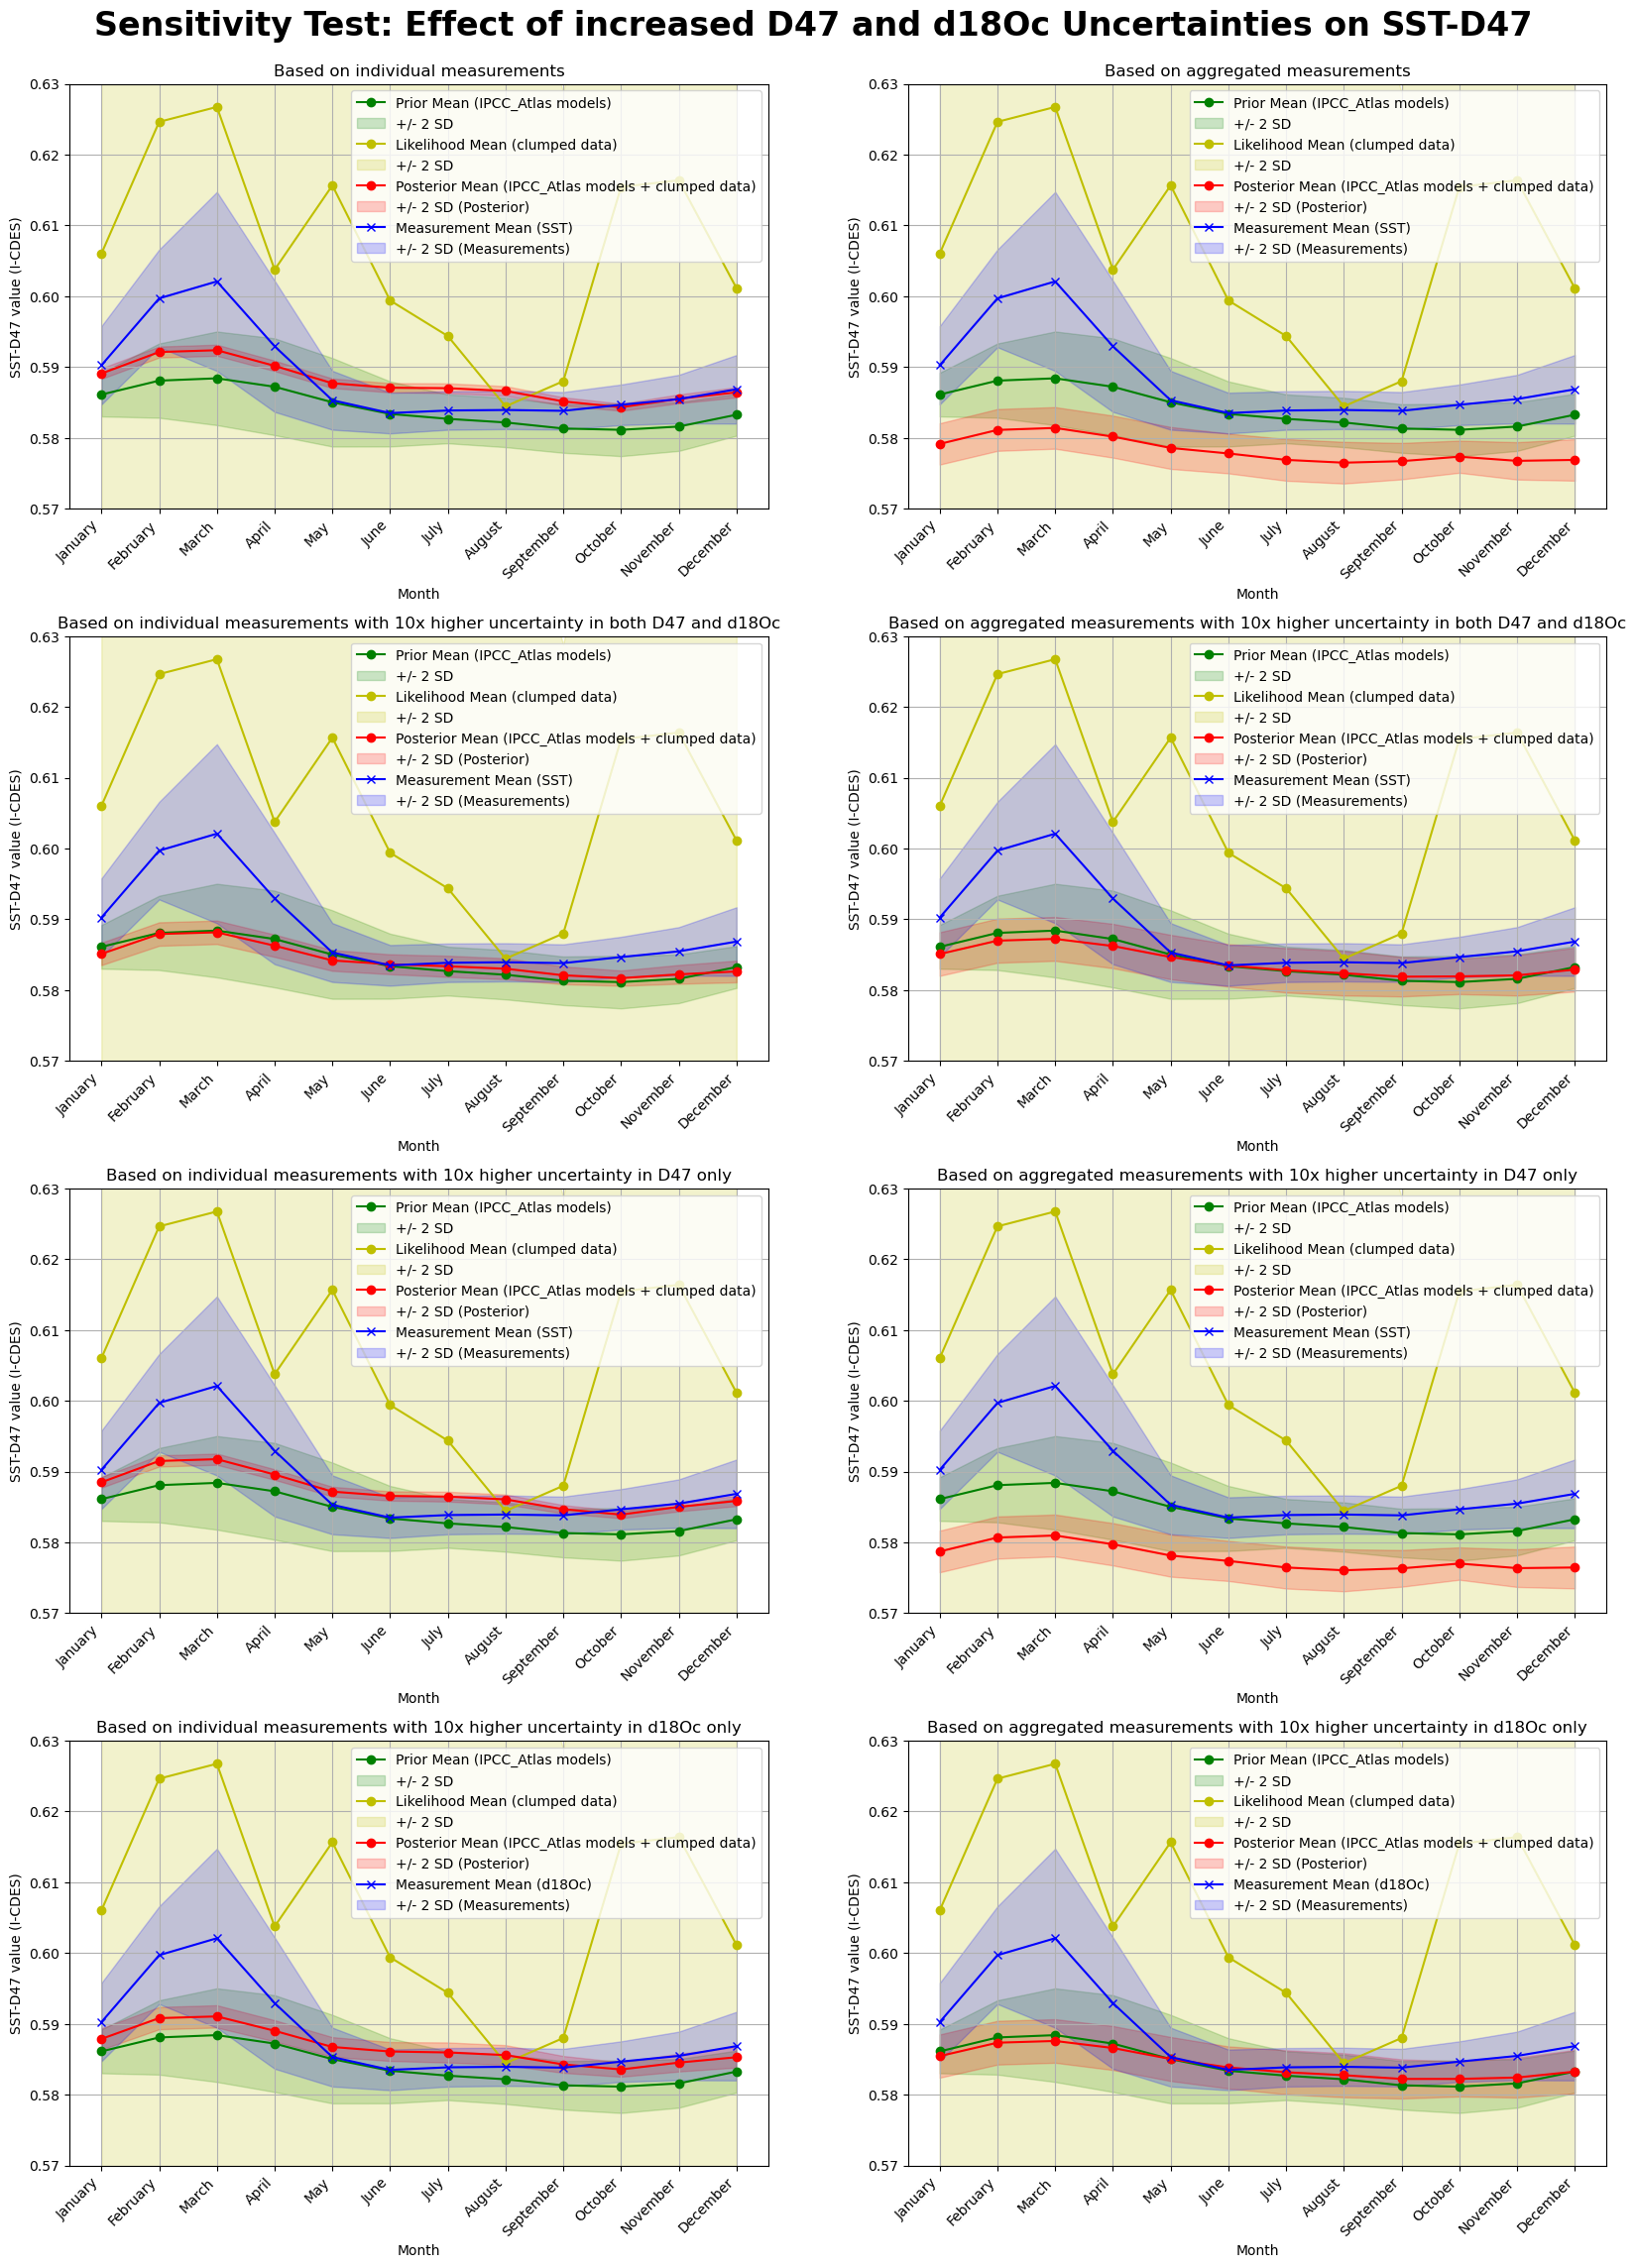

In [207]:
# Plot prior, likelihood and posterior distributions for D47 based on individual measurements

fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Sensitivity Test: Effect of increased D47 and d18Oc Uncertainties on SST-D47', fontsize=24, fontweight='bold') # Provide title for the entire figure
plt.subplots_adjust(top=0.95) # Adjust top spacing to fit the title
plt.subplots_adjust(hspace=0.3) # Adjust vertical spacing between subplots to prevent overlap between titles and x-axis labels

# -- PANEL 1 -- DATA BASED ON INDIVIDUAL MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC = np.sqrt(np.diag(cov_post_SST_D47_monthlySC))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))

# PRIOR
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 0].plot(months_scale, mu_post_SST_D47_monthlySC, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC - 2 * std_post_SST_D47_monthlySC,
    mu_post_SST_D47_monthlySC + 2 * std_post_SST_D47_monthlySC,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
# Set x-ticks and labels
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Based on individual measurements')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[0, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[0, 0].legend()
axes[0, 0].grid(True)

# -- PANEL 2 -- DATA BASED ON AGGREGATED MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))

# PRIOR
axes[0, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated - 2 * std_post_SST_D47_monthly_aggregated,
    mu_post_SST_D47_monthly_aggregated + 2 * std_post_SST_D47_monthly_aggregated,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Based on aggregated measurements')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[0, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[0, 1].legend()
axes[0, 1].grid(True)

# -- PANEL 3 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC_HU = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU))

# PRIOR
axes[1, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 0].plot(months_scale, mu_post_SST_D47_monthlySC_HU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_HU - 2 * std_post_SST_D47_monthlySC_HU,
    mu_post_SST_D47_monthlySC_HU + 2 * std_post_SST_D47_monthlySC_HU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Based on individual measurements with 10x higher uncertainty in both D47 and d18Oc')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[1, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[1, 0].legend()

# -- PANEL 4 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated_HU = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU))

# PRIOR
axes[1, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_HU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_HU - 2 * std_post_SST_D47_monthly_aggregated_HU,
    mu_post_SST_D47_monthly_aggregated_HU + 2 * std_post_SST_D47_monthly_aggregated_HU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in both D47 and d18Oc')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[1, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[1, 1].legend()
axes[1, 1].grid(True)

# -- PANEL 5 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC_HU_D47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_D47))

# PRIOR
axes[2, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 0].plot(months_scale, mu_post_SST_D47_monthlySC_HU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_HU_D47 - 2 * std_post_SST_D47_monthlySC_HU_D47,
    mu_post_SST_D47_monthlySC_HU_D47 + 2 * std_post_SST_D47_monthlySC_HU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 0].set_xticks(months_scale)
axes[2, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 0].set_title('Based on individual measurements with 10x higher uncertainty in D47 only')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[2, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[2, 0].legend()
axes[2, 0].grid(True)

# -- PANEL 6 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated_HU_D47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_D47))

# PRIOR
axes[2, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_HU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_HU_D47 - 2 * std_post_SST_D47_monthly_aggregated_HU_D47,
    mu_post_SST_D47_monthly_aggregated_HU_D47 + 2 * std_post_SST_D47_monthly_aggregated_HU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 1].set_xticks(months_scale)
axes[2, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in D47 only')
axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[2, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[2, 1].legend()
axes[2, 1].grid(True)

# -- PANEL 7 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_SST_D47_monthlySC_HU_d18O = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_d18O))

# PRIOR
axes[3, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly - 2 * std_prior_SST_D47_monthly,
    mu_prior_SST_D47_monthly + 2 * std_prior_SST_D47_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 0].plot(months_scale, mu_post_SST_D47_monthlySC_HU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_HU_d18O - 2 * std_post_SST_D47_monthlySC_HU_d18O,
    mu_post_SST_D47_monthlySC_HU_d18O + 2 * std_post_SST_D47_monthlySC_HU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 0].set_xticks(months_scale)
axes[3, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 0].set_title('Based on individual measurements with 10x higher uncertainty in d18Oc only')
axes[3, 0].set_xlabel('Month')
axes[3, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[3, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[3, 0].legend()
axes[3, 0].grid(True)

# -- PANEL 8 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_SST_D47_monthly_aggregated_HU_d18O = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_d18O))

# PRIOR
axes[3, 1].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly - 2 * std_prior_SST_D47_monthly,
    mu_prior_SST_D47_monthly + 2 * std_prior_SST_D47_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_HU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_HU_d18O - 2 * std_post_SST_D47_monthly_aggregated_HU_d18O,
    mu_post_SST_D47_monthly_aggregated_HU_d18O + 2 * std_post_SST_D47_monthly_aggregated_HU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 1].set_xticks(months_scale)
axes[3, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in d18Oc only')
axes[3, 1].set_xlabel('Month')
axes[3, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[3, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[3, 1].legend()
axes[3, 1].grid(True)

# Show plot
plt.show()

### Plot results of uncertainty test with reduced uncertainty on D47 (SST) assimilation

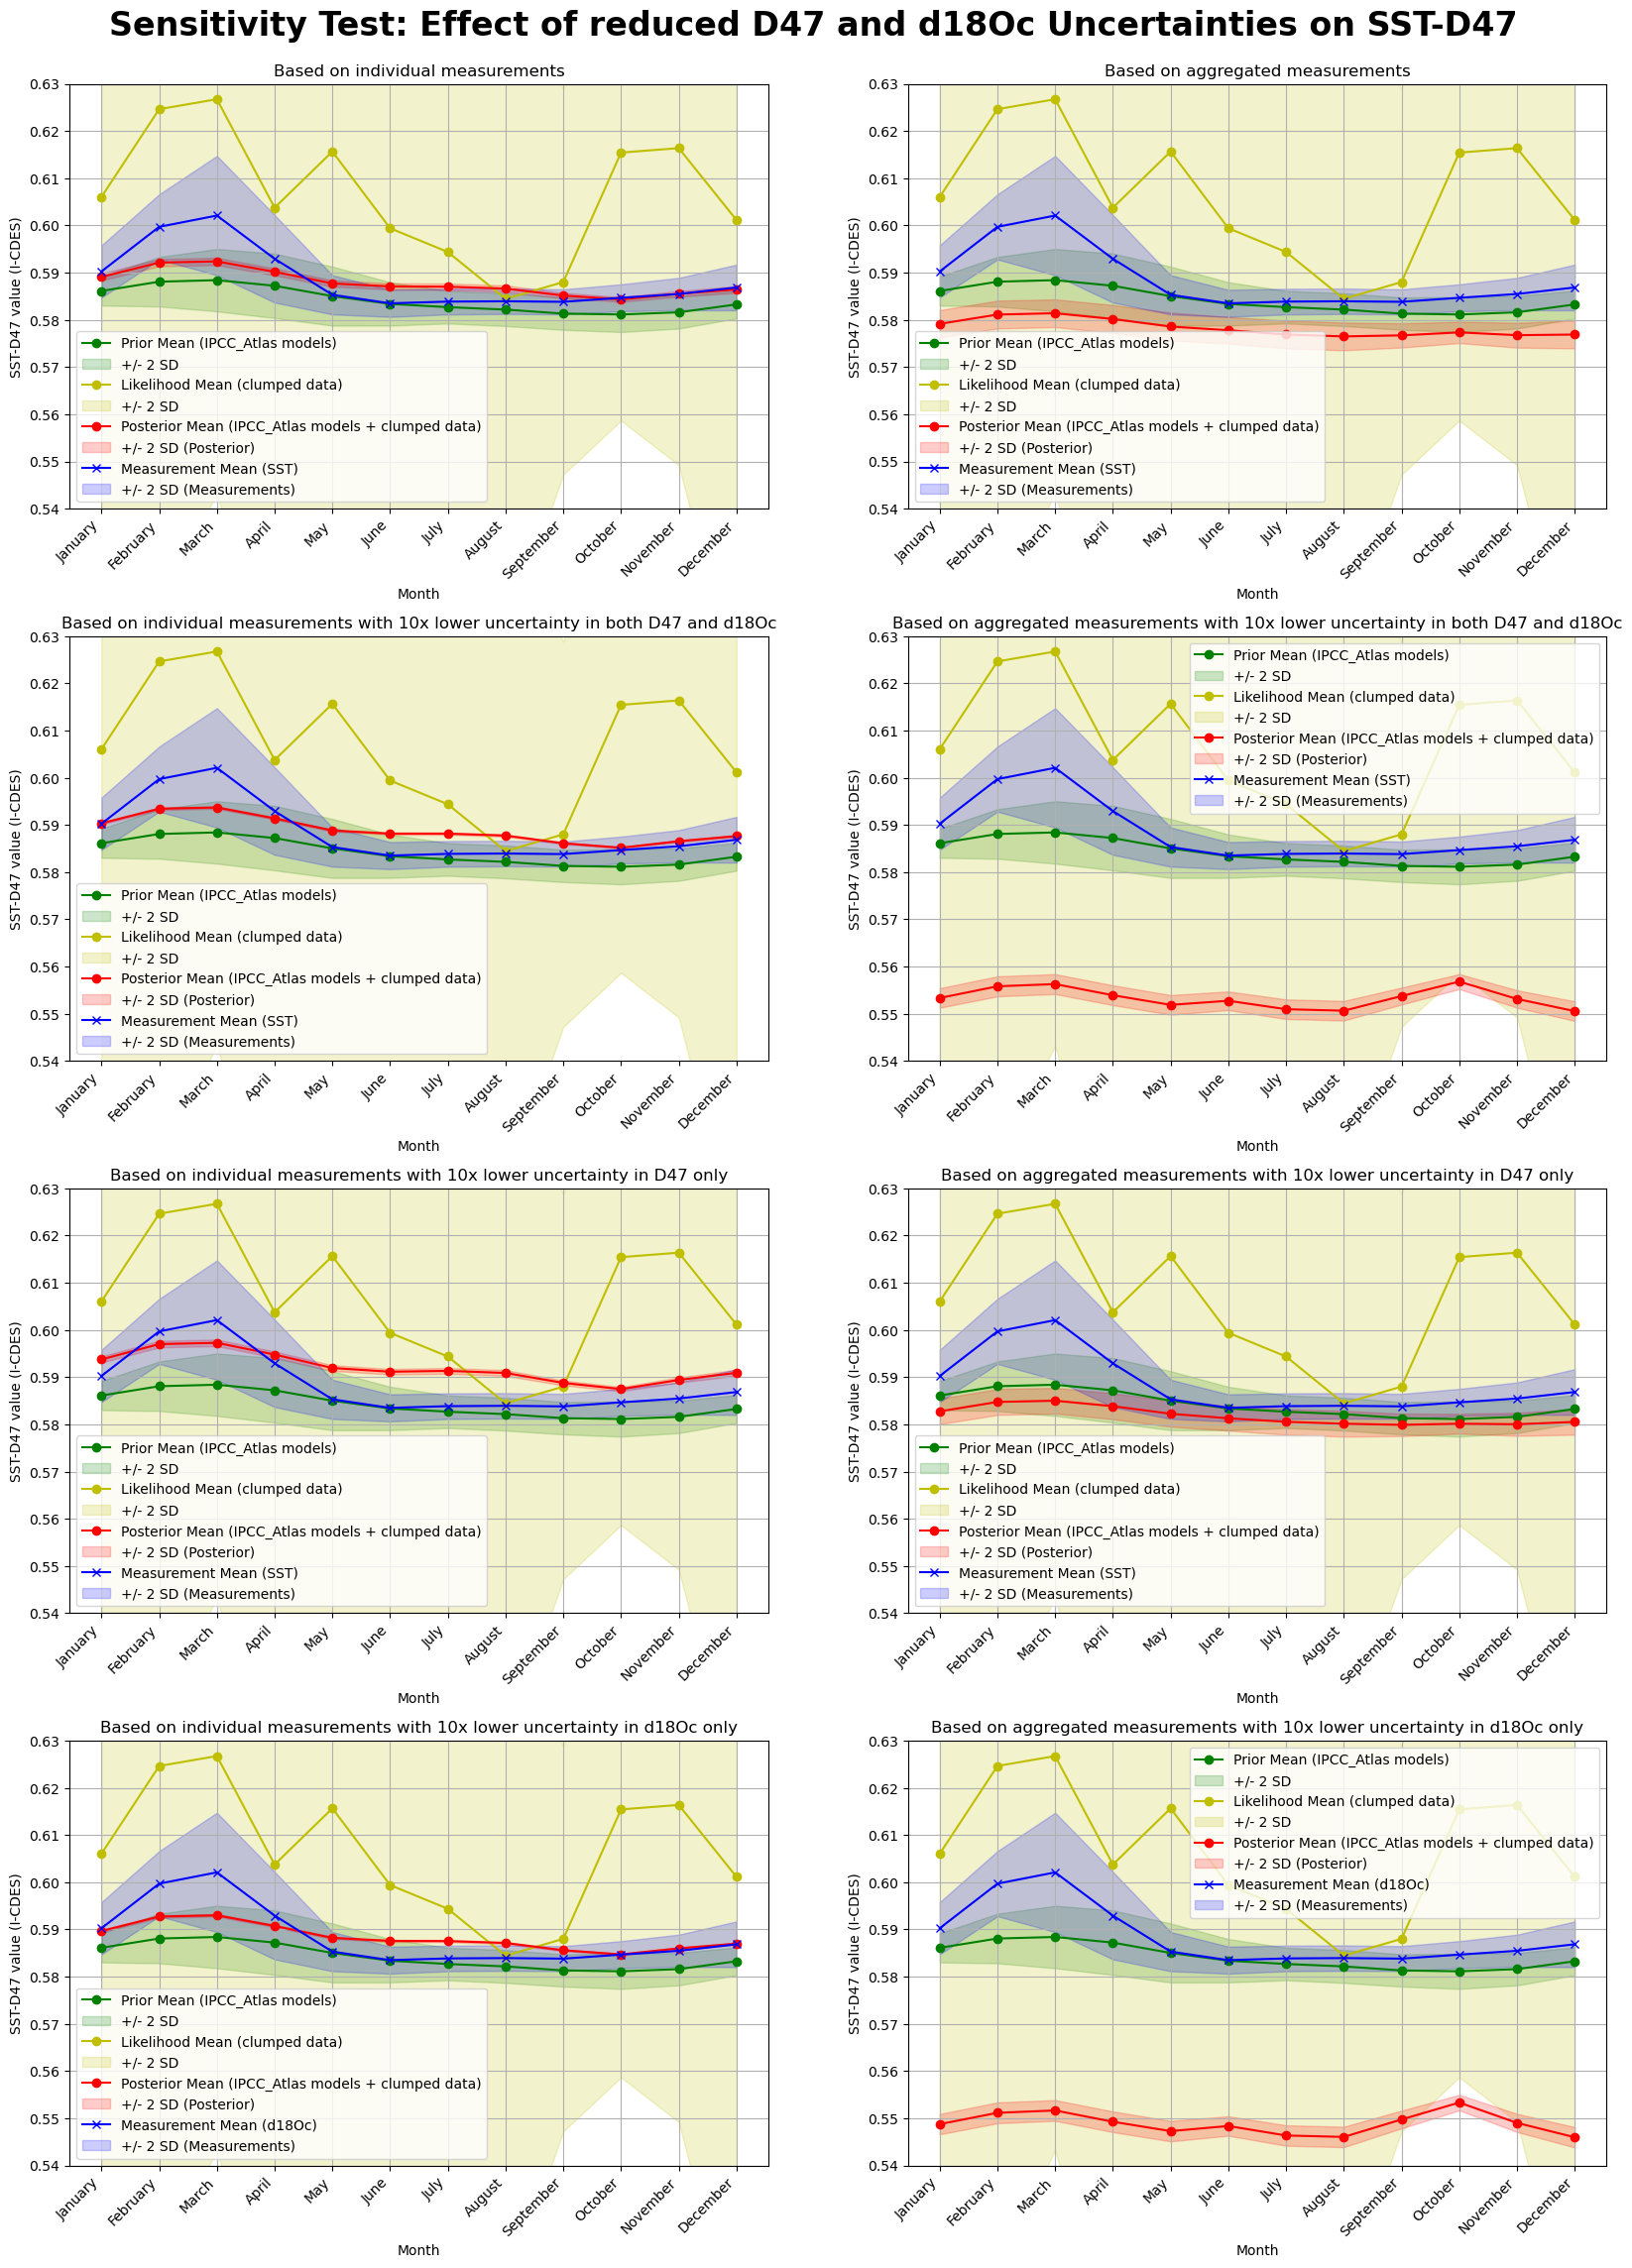

In [208]:
# Plot prior, likelihood and posterior distributions for D47 based on individual measurements

fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Sensitivity Test: Effect of reduced D47 and d18Oc Uncertainties on SST-D47', fontsize=24, fontweight='bold') # Provide title for the entire figure
plt.subplots_adjust(top=0.95) # Adjust top spacing to fit the title
plt.subplots_adjust(hspace=0.3) # Adjust vertical spacing between subplots to prevent overlap between titles and x-axis labels

# -- PANEL 1 -- DATA BASED ON INDIVIDUAL MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC = np.sqrt(np.diag(cov_post_SST_D47_monthlySC))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))

# PRIOR
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 0].plot(months_scale, mu_post_SST_D47_monthlySC, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC - 2 * std_post_SST_D47_monthlySC,
    mu_post_SST_D47_monthlySC + 2 * std_post_SST_D47_monthlySC,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
# Set x-ticks and labels
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Based on individual measurements')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[0, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[0, 0].legend()
axes[0, 0].grid(True)

# -- PANEL 2 -- DATA BASED ON AGGREGATED MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))

# PRIOR
axes[0, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated - 2 * std_post_SST_D47_monthly_aggregated,
    mu_post_SST_D47_monthly_aggregated + 2 * std_post_SST_D47_monthly_aggregated,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Based on aggregated measurements')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[0, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[0, 1].legend()
axes[0, 1].grid(True)

# -- PANEL 3 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC_LU = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU))

# PRIOR
axes[1, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 0].plot(months_scale, mu_post_SST_D47_monthlySC_LU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_LU - 2 * std_post_SST_D47_monthlySC_LU,
    mu_post_SST_D47_monthlySC_LU + 2 * std_post_SST_D47_monthlySC_LU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Based on individual measurements with 10x lower uncertainty in both D47 and d18Oc')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[1, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[1, 0].legend()

# -- PANEL 4 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated_LU = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU))

# PRIOR
axes[1, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_LU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_LU - 2 * std_post_SST_D47_monthly_aggregated_LU,
    mu_post_SST_D47_monthly_aggregated_LU + 2 * std_post_SST_D47_monthly_aggregated_LU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in both D47 and d18Oc')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[1, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[1, 1].legend()
axes[1, 1].grid(True)

# -- PANEL 5 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthlySC_LU_D47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_D47))

# PRIOR
axes[2, 0].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 0].plot(months_scale, mu_post_SST_D47_monthlySC_LU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_LU_D47 - 2 * std_post_SST_D47_monthlySC_LU_D47,
    mu_post_SST_D47_monthlySC_LU_D47 + 2 * std_post_SST_D47_monthlySC_LU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 0].set_xticks(months_scale)
axes[2, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 0].set_title('Based on individual measurements with 10x lower uncertainty in D47 only')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[2, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[2, 0].legend()
axes[2, 0].grid(True)

# -- PANEL 6 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated_LU_D47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_D47))

# PRIOR
axes[2, 1].plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - 2 * std_prior_SST_D47_monthly_original,
    mu_prior_SST_D47_monthly_original + 2 * std_prior_SST_D47_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_LU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_LU_D47 - 2 * std_post_SST_D47_monthly_aggregated_LU_D47,
    mu_post_SST_D47_monthly_aggregated_LU_D47 + 2 * std_post_SST_D47_monthly_aggregated_LU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 1].set_xticks(months_scale)
axes[2, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in D47 only')
axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[2, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[2, 1].legend()
axes[2, 1].grid(True)

# -- PANEL 7 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_SST_D47_monthlySC_LU_d18O = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_d18O))

# PRIOR
axes[3, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly - 2 * std_prior_SST_D47_monthly,
    mu_prior_SST_D47_monthly + 2 * std_prior_SST_D47_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 0].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 0].plot(months_scale, mu_post_SST_D47_monthlySC_LU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthlySC_LU_d18O - 2 * std_post_SST_D47_monthlySC_LU_d18O,
    mu_post_SST_D47_monthlySC_LU_d18O + 2 * std_post_SST_D47_monthlySC_LU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 0].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 0].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 0].set_xticks(months_scale)
axes[3, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 0].set_title('Based on individual measurements with 10x lower uncertainty in d18Oc only')
axes[3, 0].set_xlabel('Month')
axes[3, 0].set_ylabel('SST-D47 value (I-CDES)')
axes[3, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[3, 0].legend()
axes[3, 0].grid(True)

# -- PANEL 8 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_SST_D47_monthly_aggregated_LU_d18O = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_d18O))

# PRIOR
axes[3, 1].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly - 2 * std_prior_SST_D47_monthly,
    mu_prior_SST_D47_monthly + 2 * std_prior_SST_D47_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 1].plot(months_scale, mu_likelihood_monthly_D47, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_D47 - 2 * std_likelihood_monthly_D47,
    mu_likelihood_monthly_D47 + 2 * std_likelihood_monthly_D47,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_LU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_LU_d18O - 2 * std_post_SST_D47_monthly_aggregated_LU_d18O,
    mu_post_SST_D47_monthly_aggregated_LU_d18O + 2 * std_post_SST_D47_monthly_aggregated_LU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 1].plot(months_scale, mu_measurement_SST_D47_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 1].fill_between(
    months_scale,
    mu_measurement_SST_D47_monthly - 2 * std_measurement_SST_D47_monthly,
    mu_measurement_SST_D47_monthly + 2 * std_measurement_SST_D47_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 1].set_xticks(months_scale)
axes[3, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in d18Oc only')
axes[3, 1].set_xlabel('Month')
axes[3, 1].set_ylabel('SST-D47 value (I-CDES)')
axes[3, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[3, 1].legend()
axes[3, 1].grid(True)

# Show plot
plt.show()

### Plot results of uncertainty test with increased uncertainty on d18Oc assimilation

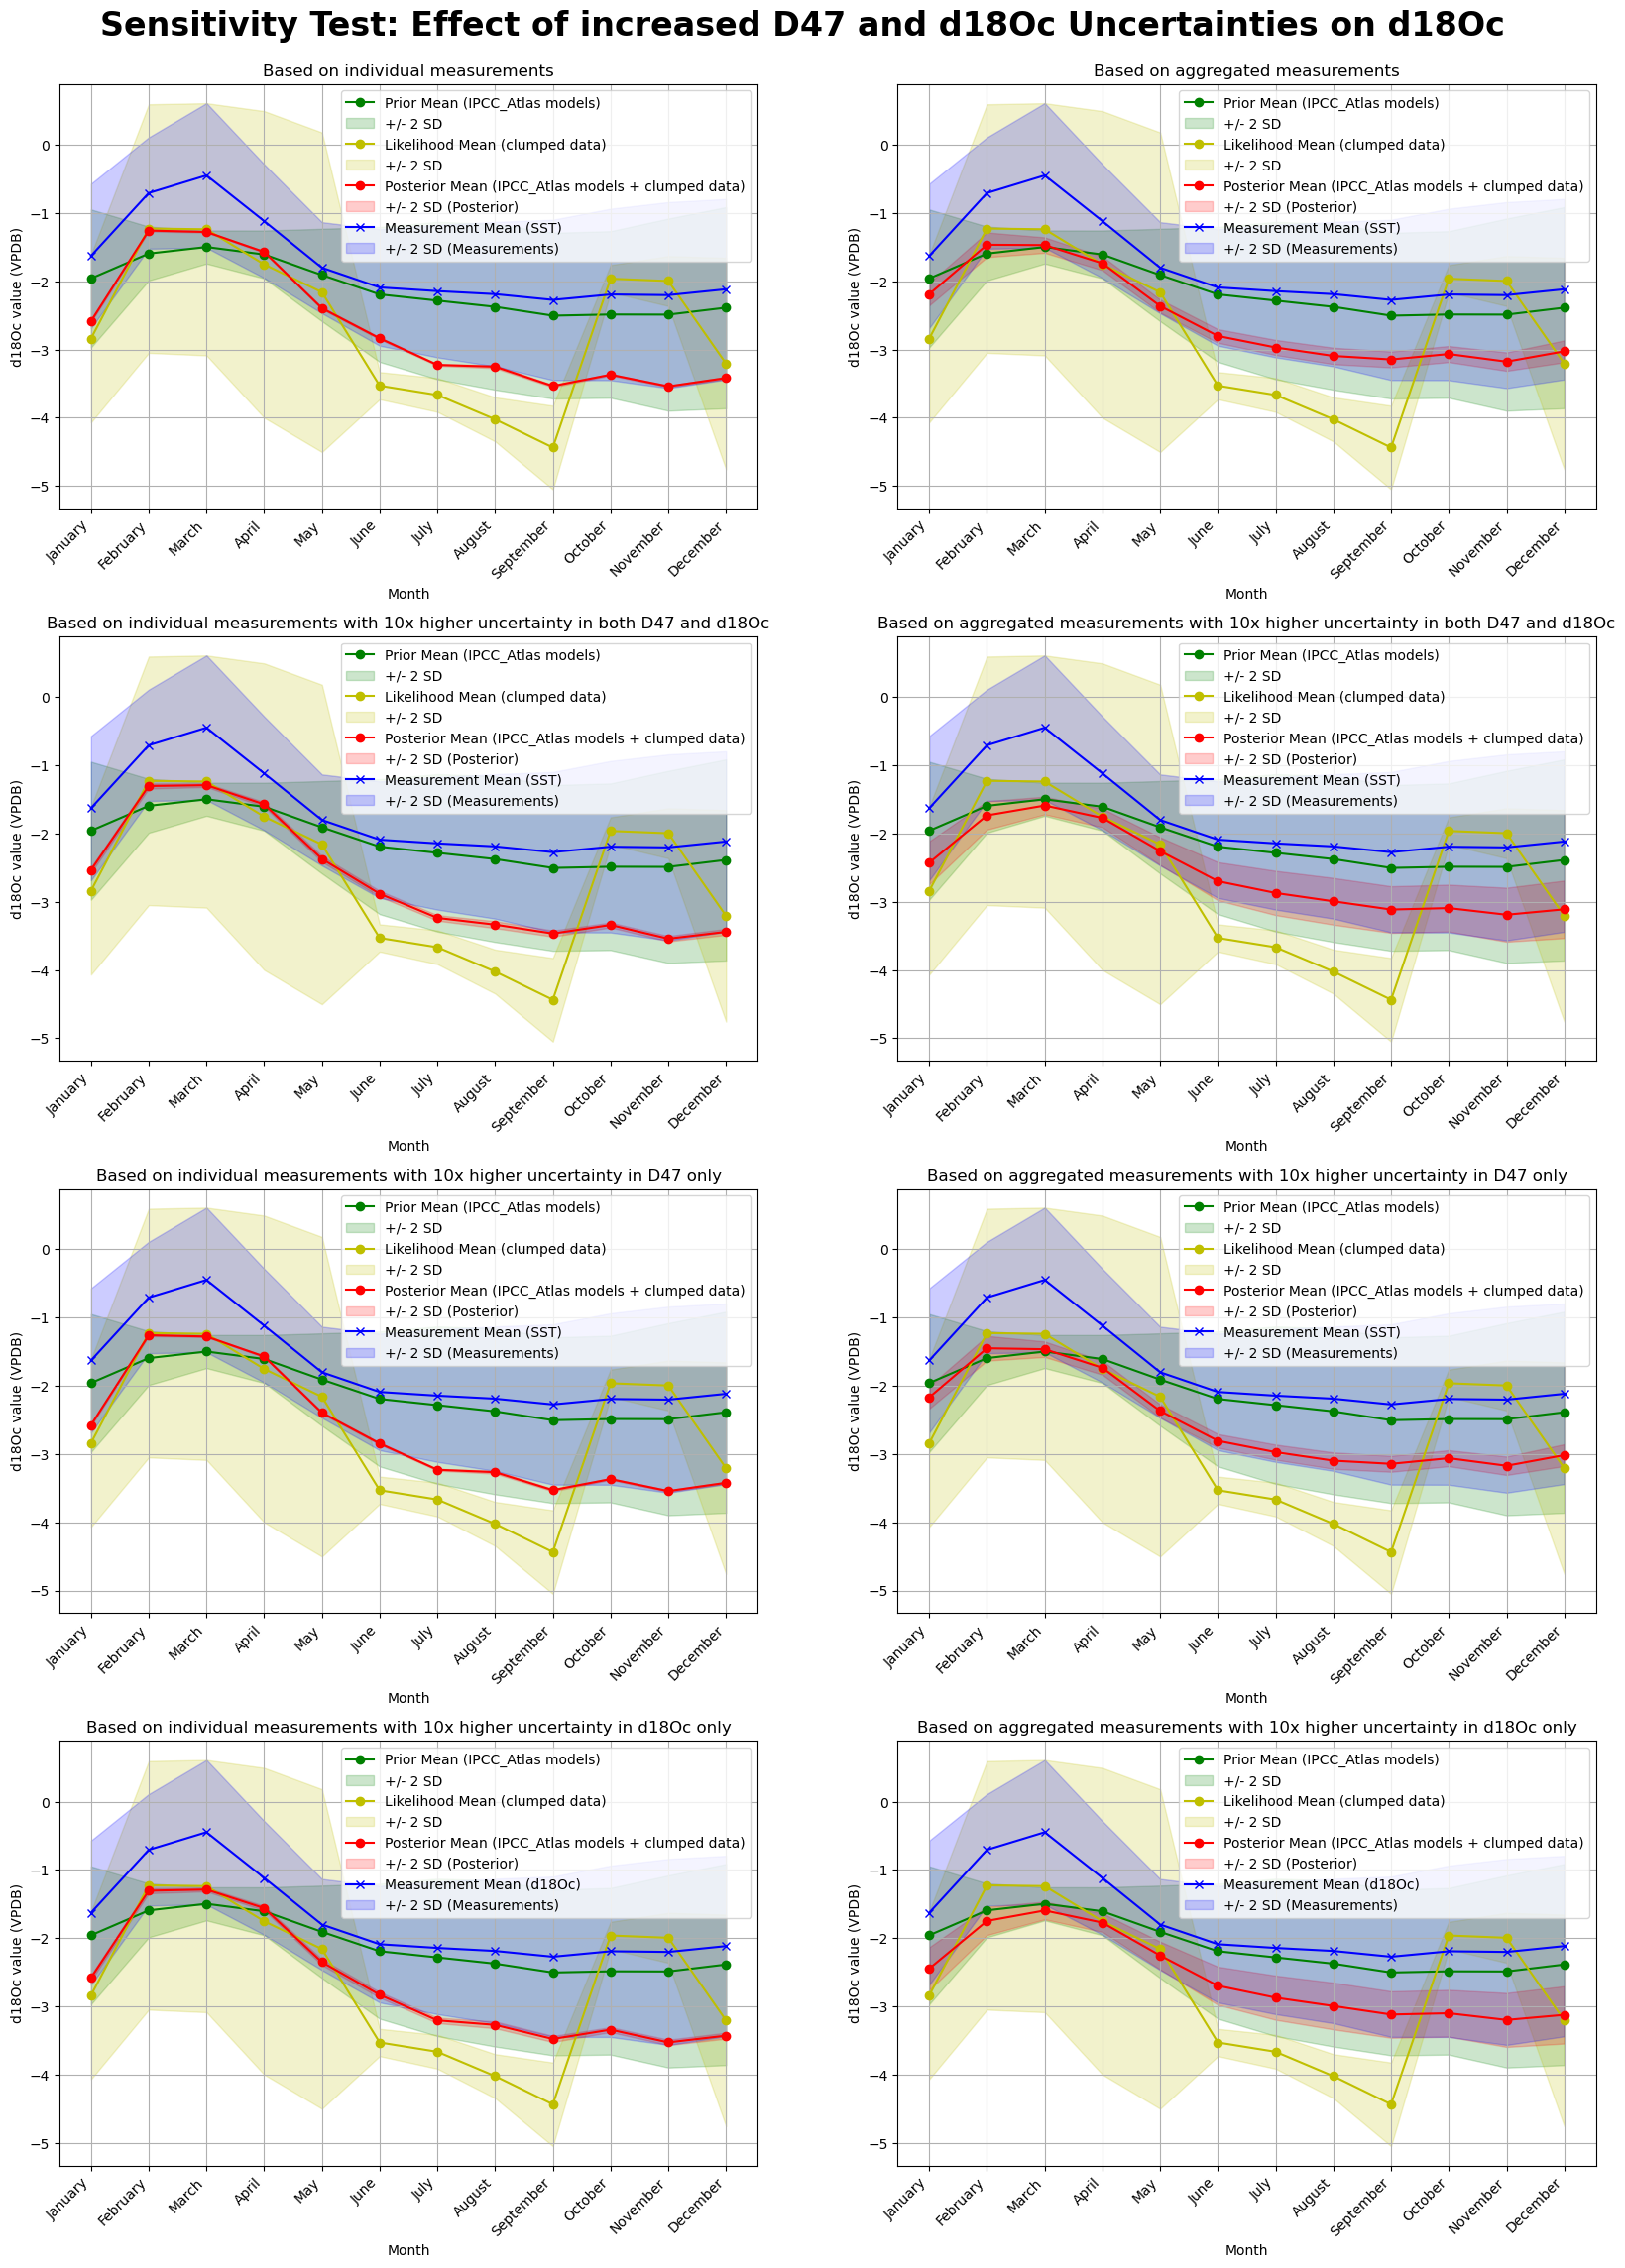

In [209]:
# Plot prior, likelihood and posterior distributions for D47 based on individual measurements

fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Sensitivity Test: Effect of increased D47 and d18Oc Uncertainties on d18Oc', fontsize=24, fontweight='bold') # Provide title for the entire figure
plt.subplots_adjust(top=0.95) # Adjust top spacing to fit the title
plt.subplots_adjust(hspace=0.3) # Adjust vertical spacing between subplots to prevent overlap between titles and x-axis labels

# -- PANEL 1 -- DATA BASED ON INDIVIDUAL MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC = np.sqrt(np.diag(cov_post_d18Oc_monthlySC))
std_prior_d18Oc_monthly_original = np.sqrt(np.diag(cov_prior_d18Oc_monthly_original))

# PRIOR
axes[0, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 0].plot(months_scale, mu_post_d18Oc_monthlySC, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC - 2 * std_post_d18Oc_monthlySC,
    mu_post_d18Oc_monthlySC + 2 * std_post_d18Oc_monthlySC,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
# Set x-ticks and labels
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Based on individual measurements')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('d18Oc value (VPDB)')
# axes[0, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[0, 0].legend()
axes[0, 0].grid(True)

# -- PANEL 2 -- DATA BASED ON AGGREGATED MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))

# PRIOR
axes[0, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated - 2 * std_post_d18Oc_monthly_aggregated,
    mu_post_d18Oc_monthly_aggregated + 2 * std_post_d18Oc_monthly_aggregated,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Based on aggregated measurements')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('d18Oc value (VPDB)')
# axes[0, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[0, 1].legend()
axes[0, 1].grid(True)

# -- PANEL 3 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC_HU = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU))

# PRIOR
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 0].plot(months_scale, mu_post_d18Oc_monthlySC_HU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_HU - 2 * std_post_d18Oc_monthlySC_HU,
    mu_post_d18Oc_monthlySC_HU + 2 * std_post_d18Oc_monthlySC_HU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Based on individual measurements with 10x higher uncertainty in both D47 and d18Oc')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value (VPDB)')
# axes[1, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[1, 0].legend()

# -- PANEL 4 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated_HU = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU))

# PRIOR
axes[1, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_HU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_HU - 2 * std_post_d18Oc_monthly_aggregated_HU,
    mu_post_d18Oc_monthly_aggregated_HU + 2 * std_post_d18Oc_monthly_aggregated_HU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in both D47 and d18Oc')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('d18Oc value (VPDB)')
# axes[1, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[1, 1].legend()
axes[1, 1].grid(True)

# -- PANEL 5 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC_HU_D47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_D47))

# PRIOR
axes[2, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 0].plot(months_scale, mu_post_d18Oc_monthlySC_HU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_HU_D47 - 2 * std_post_d18Oc_monthlySC_HU_D47,
    mu_post_d18Oc_monthlySC_HU_D47 + 2 * std_post_d18Oc_monthlySC_HU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 0].set_xticks(months_scale)
axes[2, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 0].set_title('Based on individual measurements with 10x higher uncertainty in D47 only')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('d18Oc value (VPDB)')
# axes[2, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[2, 0].legend()
axes[2, 0].grid(True)

# -- PANEL 6 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated_HU_D47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_D47))

# PRIOR
axes[2, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_HU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_HU_D47 - 2 * std_post_d18Oc_monthly_aggregated_HU_D47,
    mu_post_d18Oc_monthly_aggregated_HU_D47 + 2 * std_post_d18Oc_monthly_aggregated_HU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 1].set_xticks(months_scale)
axes[2, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in D47 only')
axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('d18Oc value (VPDB)')
# axes[2, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[2, 1].legend()
axes[2, 1].grid(True)

# -- PANEL 7 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_d18Oc_monthlySC_HU_d18O = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_d18O))

# PRIOR
axes[3, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly - 2 * std_prior_d18Oc_monthly,
    mu_prior_d18Oc_monthly + 2 * std_prior_d18Oc_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 0].plot(months_scale, mu_post_d18Oc_monthlySC_HU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_HU_d18O - 2 * std_post_d18Oc_monthlySC_HU_d18O,
    mu_post_d18Oc_monthlySC_HU_d18O + 2 * std_post_d18Oc_monthlySC_HU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 0].set_xticks(months_scale)
axes[3, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 0].set_title('Based on individual measurements with 10x higher uncertainty in d18Oc only')
axes[3, 0].set_xlabel('Month')
axes[3, 0].set_ylabel('d18Oc value (VPDB)')
# axes[3, 0].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[3, 0].legend()
axes[3, 0].grid(True)

# -- PANEL 8 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_d18Oc_monthly_aggregated_HU_d18O = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_d18O))

# PRIOR
axes[3, 1].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly - 2 * std_prior_d18Oc_monthly,
    mu_prior_d18Oc_monthly + 2 * std_prior_d18Oc_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_HU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_HU_d18O - 2 * std_post_d18Oc_monthly_aggregated_HU_d18O,
    mu_post_d18Oc_monthly_aggregated_HU_d18O + 2 * std_post_d18Oc_monthly_aggregated_HU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 1].set_xticks(months_scale)
axes[3, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 1].set_title('Based on aggregated measurements with 10x higher uncertainty in d18Oc only')
axes[3, 1].set_xlabel('Month')
axes[3, 1].set_ylabel('d18Oc value (VPDB)')
# axes[3, 1].set_ylim(0.57, 0.63)  # Set y-axis limits for better visibility
axes[3, 1].legend()
axes[3, 1].grid(True)

# Show plot
plt.show()

### Plot results of uncertainty test with reduced uncertainty on d18Oc assimilation

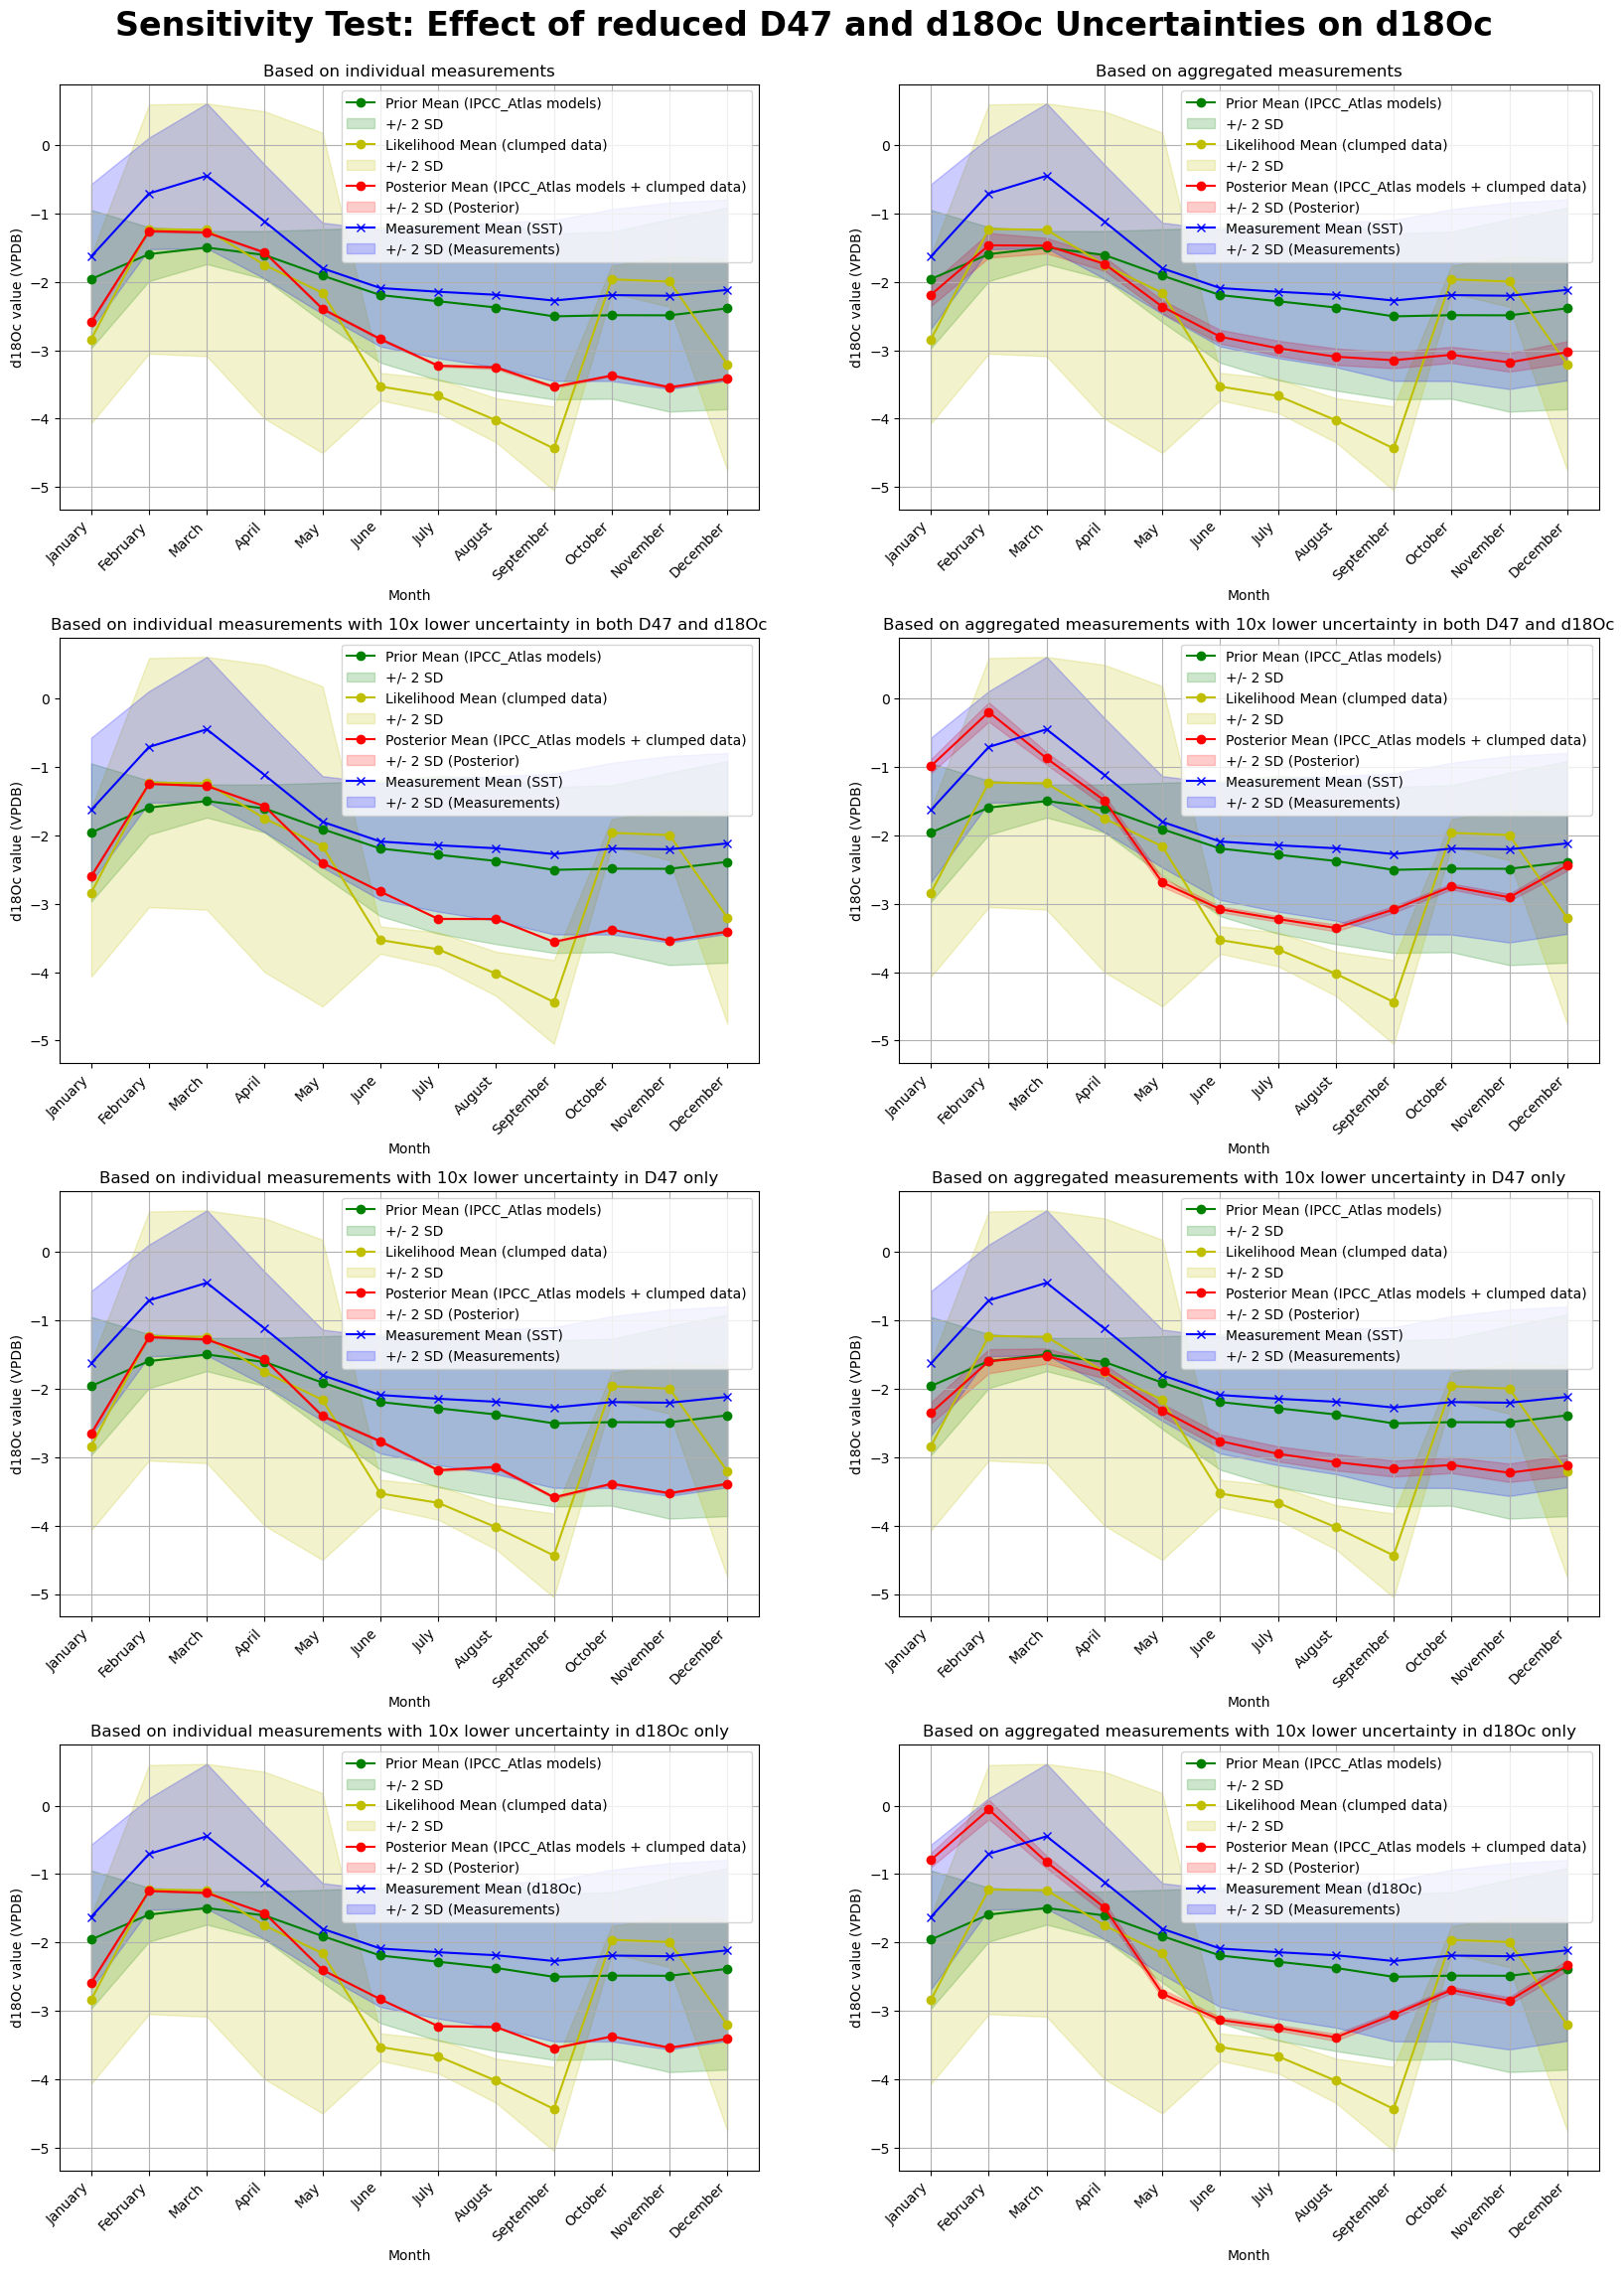

In [210]:
# Plot prior, likelihood and posterior distributions for D47 based on individual measurements

fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Sensitivity Test: Effect of reduced D47 and d18Oc Uncertainties on d18Oc', fontsize=24, fontweight='bold') # Provide title for the entire figure
plt.subplots_adjust(top=0.95) # Adjust top spacing to fit the title
plt.subplots_adjust(hspace=0.3) # Adjust vertical spacing between subplots to prevent overlap between titles and x-axis labels

# -- PANEL 1 -- DATA BASED ON INDIVIDUAL MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC = np.sqrt(np.diag(cov_post_d18Oc_monthlySC))
std_prior_d18Oc_monthly_original = np.sqrt(np.diag(cov_prior_d18Oc_monthly_original))

# PRIOR
axes[0, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 0].plot(months_scale, mu_post_d18Oc_monthlySC, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC - 2 * std_post_d18Oc_monthlySC,
    mu_post_d18Oc_monthlySC + 2 * std_post_d18Oc_monthlySC,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
# Set x-ticks and labels
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Based on individual measurements')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('d18Oc value (VPDB)')
# axes[0, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[0, 0].legend()
axes[0, 0].grid(True)

# -- PANEL 2 -- DATA BASED ON AGGREGATED MEASUREMENTS
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))

# PRIOR
axes[0, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[0, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[0, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated - 2 * std_post_d18Oc_monthly_aggregated,
    mu_post_d18Oc_monthly_aggregated + 2 * std_post_d18Oc_monthly_aggregated,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[0, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[0, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Based on aggregated measurements')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('d18Oc value (VPDB)')
# axes[0, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[0, 1].legend()
axes[0, 1].grid(True)

# -- PANEL 3 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC_LU = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU))

# PRIOR
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 0].plot(months_scale, mu_post_d18Oc_monthlySC_LU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_LU - 2 * std_post_d18Oc_monthlySC_LU,
    mu_post_d18Oc_monthlySC_LU + 2 * std_post_d18Oc_monthlySC_LU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Based on individual measurements with 10x lower uncertainty in both D47 and d18Oc')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value (VPDB)')
# axes[1, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[1, 0].legend()

# -- PANEL 4 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON BOTH D47 AND d18O
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated_LU = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU))

# PRIOR
axes[1, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[1, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[1, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_LU, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_LU - 2 * std_post_d18Oc_monthly_aggregated_LU,
    mu_post_d18Oc_monthly_aggregated_LU + 2 * std_post_d18Oc_monthly_aggregated_LU,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[1, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[1, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in both D47 and d18Oc')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('d18Oc value (VPDB)')
# axes[1, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[1, 1].legend()
axes[1, 1].grid(True)

# -- PANEL 5 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthlySC_LU_D47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_D47))

# PRIOR
axes[2, 0].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 0].plot(months_scale, mu_post_d18Oc_monthlySC_LU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_LU_D47 - 2 * std_post_d18Oc_monthlySC_LU_D47,
    mu_post_d18Oc_monthlySC_LU_D47 + 2 * std_post_d18Oc_monthlySC_LU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 0].set_xticks(months_scale)
axes[2, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 0].set_title('Based on individual measurements with 10x lower uncertainty in D47 only')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('d18Oc value (VPDB)')
# axes[2, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[2, 0].legend()
axes[2, 0].grid(True)

# -- PANEL 6 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON D47 ONLY
# Calculate the updated seasonal posterior for SST_D47
std_post_d18Oc_monthly_aggregated_LU_D47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_D47))

# PRIOR
axes[2, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[2, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[2, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_LU_D47, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_LU_D47 - 2 * std_post_d18Oc_monthly_aggregated_LU_D47,
    mu_post_d18Oc_monthly_aggregated_LU_D47 + 2 * std_post_d18Oc_monthly_aggregated_LU_D47,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[2, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (SST)', color='b', marker='x')
axes[2, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[2, 1].set_xticks(months_scale)
axes[2, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in D47 only')
axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('d18Oc value (VPDB)')
# axes[2, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[2, 1].legend()
axes[2, 1].grid(True)

# -- PANEL 7 -- DATA BASED ON INDIVIDUAL MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_d18Oc_monthlySC_LU_d18O = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_d18O))

# PRIOR
axes[3, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly - 2 * std_prior_d18Oc_monthly,
    mu_prior_d18Oc_monthly + 2 * std_prior_d18Oc_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 0].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 0].plot(months_scale, mu_post_d18Oc_monthlySC_LU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 0].fill_between(
    months_scale,
    mu_post_d18Oc_monthlySC_LU_d18O - 2 * std_post_d18Oc_monthlySC_LU_d18O,
    mu_post_d18Oc_monthlySC_LU_d18O + 2 * std_post_d18Oc_monthlySC_LU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 0].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 0].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 0].set_xticks(months_scale)
axes[3, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 0].set_title('Based on individual measurements with 10x lower uncertainty in d18Oc only')
axes[3, 0].set_xlabel('Month')
axes[3, 0].set_ylabel('d18Oc value (VPDB)')
# axes[3, 0].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[3, 0].legend()
axes[3, 0].grid(True)

# -- PANEL 8 -- DATA BASED ON AGGREGATED MEASUREMENTS WITH HIGHER UNCERTAINTY ON d18Oc ONLY
# Calculate the updated seasonal posterior for D47
std_post_d18Oc_monthly_aggregated_LU_d18O = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_d18O))

# PRIOR
axes[3, 1].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior Mean (IPCC_Atlas models)', color='g', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly - 2 * std_prior_d18Oc_monthly,
    mu_prior_d18Oc_monthly + 2 * std_prior_d18Oc_monthly,
    color='g',
    alpha=0.2,
    label='+/- 2 SD'
)
# LIKELIHOOD
axes[3, 1].plot(months_scale, mu_likelihood_monthly_d18Oc, label='Likelihood Mean (clumped data)', color='y', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_d18Oc - 2 * std_likelihood_monthly_d18Oc,
    mu_likelihood_monthly_d18Oc + 2 * std_likelihood_monthly_d18Oc,
    color='y',
    alpha=0.2,
    label='+/- 2 SD'
)
# POSTERIOR
axes[3, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated_LU_d18O, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axes[3, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated_LU_d18O - 2 * std_post_d18Oc_monthly_aggregated_LU_d18O,
    mu_post_d18Oc_monthly_aggregated_LU_d18O + 2 * std_post_d18Oc_monthly_aggregated_LU_d18O,
    color='r',
    alpha=0.2,
    label='+/- 2 SD (Posterior)'
)
# MEASUREMENT DATA
axes[3, 1].plot(months_scale, mu_measurement_d18Oc_monthly, label='Measurement Mean (d18Oc)', color='b', marker='x')
axes[3, 1].fill_between(
    months_scale,
    mu_measurement_d18Oc_monthly - 2 * std_measurement_d18Oc_monthly,
    mu_measurement_d18Oc_monthly + 2 * std_measurement_d18Oc_monthly,
    color='b',
    alpha=0.2,
    label='+/- 2 SD (Measurements)'
)
axes[3, 1].set_xticks(months_scale)
axes[3, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[3, 1].set_title('Based on aggregated measurements with 10x lower uncertainty in d18Oc only')
axes[3, 1].set_xlabel('Month')
axes[3, 1].set_ylabel('d18Oc value (VPDB)')
# axes[3, 1].set_ylim(0.54, 0.63)  # Set y-axis limits for better visibility
axes[3, 1].legend()
axes[3, 1].grid(True)

# Show plot
plt.show()

### Aggregate statistics on posterior outcomes on SST-D47 and d18Oc for all cases

In [ ]:
# Prepare the data for the table
data = {
    "Data Type": [
        "In situ measurements",
        "Individual Measurements",
        "Individual Measurements (SD D47 * 10)",
        "Individual Measurements (SD d18Oc * 10)",
        "Individual Measurements (both SDs * 10)",
        "Individual Measurements (SD D47 * 0.1)",
        "Individual Measurements (SD d18Oc * 0.1)",
        "Individual Measurements (both SDs * 0.1)",
        "Aggregated Measurements",
        "Aggregated Measurements (SD D47 * 10)",
        "Aggregated Measurements (SD d18Oc * 10)",
        "Aggregated Measurements (both SDs * 10)",
        "Aggregated Measurements (SD D47 * 0.1)",
        "Aggregated Measurements (SD d18Oc * 0.1)",
        "Aggregated Measurements (both SDs * 0.1)"
    ]
}

# Add monthly means and standard deviations to the data dictionary
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Process and rename the means and standard deviations for each data source
D47_means_individual = mu_post_SST_D47_monthlySC
D47_stds_individual = np.sqrt(np.diag(cov_post_SST_D47_monthlySC))
D47_means_individual_hu_d47 = mu_post_SST_D47_monthlySC_HU_D47
D47_stds_individual_hu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_D47))
D47_means_individual_hu_d18o = mu_post_SST_D47_monthlySC_HU_d18O
D47_stds_individual_hu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU_d18O))
D47_means_individual_hu = mu_post_SST_D47_monthlySC_HU
D47_stds_individual_hu = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_HU))
D47_means_individual_lu_d47 = mu_post_SST_D47_monthlySC_LU_D47
D47_stds_individual_lu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_D47))
D47_means_individual_lu_d18o = mu_post_SST_D47_monthlySC_LU_d18O
D47_stds_individual_lu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU_d18O))
D47_means_individual_lu = mu_post_SST_D47_monthlySC_LU
D47_stds_individual_lu = np.sqrt(np.diag(cov_post_SST_D47_monthlySC_LU))

D47_means_aggregated = mu_post_SST_D47_monthly_aggregated
D47_stds_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))
D47_means_aggregated_hu_d47 = mu_post_SST_D47_monthly_aggregated_HU_D47
D47_stds_aggregated_hu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_D47))
D47_means_aggregated_hu_d18o = mu_post_SST_D47_monthly_aggregated_HU_d18O
D47_stds_aggregated_hu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU_d18O))
D47_means_aggregated_hu = mu_post_SST_D47_monthly_aggregated_HU
D47_stds_aggregated_hu = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_HU))
D47_means_aggregated_lu_d47 = mu_post_SST_D47_monthly_aggregated_LU_D47
D47_stds_aggregated_lu_d47 = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_D47))
D47_means_aggregated_lu_d18o = mu_post_SST_D47_monthly_aggregated_LU_d18O
D47_stds_aggregated_lu_d18o = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU_d18O))
D47_means_aggregated_lu = mu_post_SST_D47_monthly_aggregated_LU
D47_stds_aggregated_lu = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_LU))

d18Oc_means_individual = mu_post_d18Oc_monthlySC
d18Oc_stds_individual = np.sqrt(np.diag(cov_post_d18Oc_monthlySC))
d18Oc_means_individual_hu_d47 = mu_post_d18Oc_monthlySC_HU_D47
d18Oc_stds_individual_hu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_D47))
d18Oc_means_individual_hu_d18o = mu_post_d18Oc_monthlySC_HU_d18O
d18Oc_stds_individual_hu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU_d18O))
d18Oc_means_individual_hu = mu_post_d18Oc_monthlySC_HU
d18Oc_stds_individual_hu = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_HU))
d18Oc_means_individual_lu_d47 = mu_post_d18Oc_monthlySC_LU_D47
d18Oc_stds_individual_lu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_D47))
d18Oc_means_individual_lu_d18o = mu_post_d18Oc_monthlySC_LU_d18O
d18Oc_stds_individual_lu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU_d18O))
d18Oc_means_individual_lu = mu_post_d18Oc_monthlySC_LU
d18Oc_stds_individual_lu = np.sqrt(np.diag(cov_post_d18Oc_monthlySC_LU))

d18Oc_means_aggregated = mu_post_d18Oc_monthly_aggregated
d18Oc_stds_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))
d18Oc_means_aggregated_hu_d47 = mu_post_d18Oc_monthly_aggregated_HU_D47
d18Oc_stds_aggregated_hu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_D47))
d18Oc_means_aggregated_hu_d18o = mu_post_d18Oc_monthly_aggregated_HU_d18O
d18Oc_stds_aggregated_hu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU_d18O))
d18Oc_means_aggregated_hu = mu_post_d18Oc_monthly_aggregated_HU
d18Oc_stds_aggregated_hu = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_HU))
d18Oc_means_aggregated_lu_d47 = mu_post_d18Oc_monthly_aggregated_LU_D47
d18Oc_stds_aggregated_lu_d47 = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_D47))
d18Oc_means_aggregated_lu_d18o = mu_post_d18Oc_monthly_aggregated_LU_d18O
d18Oc_stds_aggregated_lu_d18o = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU_d18O))
d18Oc_means_aggregated_lu = mu_post_d18Oc_monthly_aggregated_LU
d18Oc_stds_aggregated_lu = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated_LU))

# Combine all means and standard deviations into the data structure
all_D47_means = [
    mu_measurement_SST_D47_monthly,
    D47_means_individual,
    D47_means_individual_hu_d47,
    D47_means_individual_hu_d18o,
    D47_means_individual_hu,
    D47_means_individual_lu_d47,
    D47_means_individual_lu_d18o,
    D47_means_individual_lu,
    D47_means_aggregated,
    D47_means_aggregated_hu_d47,
    D47_means_aggregated_hu_d18o,
    D47_means_aggregated_hu,
    D47_means_aggregated_lu_d47,
    D47_means_aggregated_lu_d18o,
    D47_means_aggregated_lu
]
all_D47_stds = [
    std_measurement_SST_D47_monthly,
    D47_stds_individual,
    D47_stds_individual_hu_d47,
    D47_stds_individual_hu_d18o,
    D47_stds_individual_hu,
    D47_stds_individual_lu_d47,
    D47_stds_individual_lu_d18o,
    D47_stds_individual_lu,
    D47_stds_aggregated,
    D47_stds_aggregated_hu_d47,
    D47_stds_aggregated_hu_d18o,
    D47_stds_aggregated_hu,
    D47_stds_aggregated_lu_d47,
    D47_stds_aggregated_lu_d18o,
    D47_stds_aggregated_lu
]

all_d18Oc_means = [
    mu_measurement_d18Oc_monthly,
    d18Oc_means_individual,
    d18Oc_means_individual_hu_d47,
    d18Oc_means_individual_hu_d18o,
    d18Oc_means_individual_hu,
    d18Oc_means_individual_lu_d47,
    d18Oc_means_individual_lu_d18o,
    d18Oc_means_individual_lu,
    d18Oc_means_aggregated,
    d18Oc_means_aggregated_hu_d47,
    d18Oc_means_aggregated_hu_d18o,
    d18Oc_means_aggregated_hu,
    d18Oc_means_aggregated_lu_d47,
    d18Oc_means_aggregated_lu_d18o,
    d18Oc_means_aggregated_lu
]
all_d18Oc_stds = [
    std_measurement_d18Oc_monthly,
    d18Oc_stds_individual,
    d18Oc_stds_individual_hu_d47,
    d18Oc_stds_individual_hu_d18o,
    d18Oc_stds_individual_hu,
    d18Oc_stds_individual_lu_d47,
    d18Oc_stds_individual_lu_d18o,
    d18Oc_stds_individual_lu,
    d18Oc_stds_aggregated,
    d18Oc_stds_aggregated_hu_d47,
    d18Oc_stds_aggregated_hu_d18o,
    d18Oc_stds_aggregated_hu,
    d18Oc_stds_aggregated_lu_d47,
    d18Oc_stds_aggregated_lu_d18o,
    d18Oc_stds_aggregated_lu
]

# Create a dictionary to store all the data
all_data = {"Data Type": data["Data Type"]}

# Add D47 means and stds
for i, month in enumerate(months):
    all_data[f"{month} D47 Mean"] = [means[i] for means in all_D47_means]
    all_data[f"{month} D47 Std"] = [stds[i] for stds in all_D47_stds]

# Add d18Oc means and stds
for i, month in enumerate(months):
    all_data[f"{month} d18Oc Mean"] = [means[i] for means in all_d18Oc_means]
    all_data[f"{month} d18Oc Std"] = [stds[i] for stds in all_d18Oc_stds]

# Create the Pandas DataFrame
all_uncertainty_test_table_df = pd.DataFrame(all_data)

# Set the 'Data Type' column as the index
all_uncertainty_test_table_df = all_uncertainty_test_table_df.set_index("Data Type")

# Export the table to a CSV file
all_uncertainty_test_table_df.to_csv("Sensitivity_test_D47_d18Oc_uncertainties/all_uncertainty_test_table.csv")

print("Combined data exported to Sensitivity_test_D47_d18Oc_uncertainties/all_uncertainty_test_table.csv")

# Potential avenues for further testing/exploration:
* Effect of increased/reduced uncertainty of inputs on other assembled climate variables
* Aggregate table with statistics of outcomes contingent on uncertainty (annual means and seasonal range +/- uncertainty of posterior)